# <center><u>Face Detection and Face Recognition</u></center>

## <u>Importing Required Libraries</u>

In [1]:
import os
import cv2
import random
import time
import numpy as np
import pandas as pd
import seaborn as sns
import face_recognition
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from zipfile import ZipFile

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Reshape,
    UpSampling2D,
    Concatenate,
)
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img

import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
K.clear_session()
%matplotlib inline


***
***
# <u>PART A</u>
***

## <u>Data Preprocessing and Visualization</u>

### Import the data "Images.npy"

In [2]:
data_path = "C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 9 - Computer Vision (Week 32 to Week 37)/Project/Datasets/Images.npy"

In [3]:
image_data = np.load(data_path, allow_pickle=True)

> We are keeping **allow_pickle=True** as our file may contain Python objects such as dictionaries or tuples, and enabling it ensures all these objects are deserialized properly
>
> Now that we have read the file, let's explore some information around our loaded dataset

<u>**Shape and Size of the dataset**

In [4]:
print("Shape of the Images dataset:", image_data.shape)
print("Size of the Images dataset:", image_data.size)

Shape of the Images dataset: (393, 2)
Size of the Images dataset: 786


<u>**Type of the dataset**

In [5]:
print("Type of Images Dataset:", type(image_data)) 

Type of Images Dataset: <class 'numpy.ndarray'>


> We see that our data consists of 2 columns and 393 images.
> <br>Also, the dataset is of type Numpy Arrary
> <br> Let's try seeing the size of the image in 1st column

In [6]:
image_data[0][0].shape

(333, 650, 3)

> We can see that the image is of size 333 by 650 and is of 3 channels i.e. it is an RGB image.

> Let's see 1 sample data for our dataset

In [7]:
print("10th Record, Column 1 - ")
image_data[10][0]

10th Record, Column 1 - 


array([[[ 6, 42, 56],
        [ 6, 42, 56],
        [ 6, 42, 56],
        ...,
        [ 9, 47, 60],
        [ 9, 47, 60],
        [ 9, 47, 60]],

       [[ 6, 42, 56],
        [ 6, 42, 56],
        [ 6, 42, 56],
        ...,
        [ 9, 47, 60],
        [ 9, 47, 60],
        [ 9, 47, 60]],

       [[ 6, 42, 56],
        [ 6, 42, 56],
        [ 6, 42, 56],
        ...,
        [ 9, 47, 60],
        [ 9, 47, 60],
        [ 9, 47, 60]],

       ...,

       [[ 3,  3,  3],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 1,  1,  1],
        ...,
        [ 8,  8,  8],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 9,  9,  9],
        [ 5,  5,  5],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 3,  3,  3],
        [ 4,  4,  4]]], dtype=uint8)

> Here, we can see that **column 1 has the Image Data** in our dataset and is of numPy Array type as we have discussed above as well and represents RGB image where each entry (e.g., [6, 42, 56]) is a pixel in the RGB format, where:
> * The first dimension corresponds to the height
> * The second dimension corresponds to the width
> * The third dimension (length = 3) stores RGB values

In [8]:
print("10th Record, Column 2 - ")
image_data[10][1]

10th Record, Column 2 - 


[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.046296296296296294, 'y': 0.16354166666666667},
   {'x': 0.2037037037037037, 'y': 0.2989583333333333}],
  'imageWidth': 648,
  'imageHeight': 960},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3194444444444444, 'y': 0.1375},
   {'x': 0.5570987654320988, 'y': 0.29583333333333334}],
  'imageWidth': 648,
  'imageHeight': 960},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.5648148148148148, 'y': 0.1875},
   {'x': 0.7145061728395061, 'y': 0.30520833333333336}],
  'imageWidth': 648,
  'imageHeight': 960},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.7160493827160493, 'y': 0.209375},
   {'x': 0.8333333333333334, 'y': 0.30625}],
  'imageWidth': 648,
  'imageHeight': 960},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.8225308641975309, 'y': 0.23125},
   {'x': 0.9429012345679012, 'y': 0.3177083333333333}],
  'imageWidth': 648,
  'imageHeight': 960}]

> **2nd column in our dataset comprises of the Metadata** and is of a list of dictionaries type containing metadata for five labeled bounding boxes where each dictionary provides information about a detected face, including below:
> * **label:** 'Face' in our example
> * **points:** there are 2 points, x and y, defining the bounding box as fraction of the image's width and height
> * **imageWidth and imageHeight:**  show the original dimensions of the image
>
>Also, our image consists of **five faces** owing to 5 entries for bounding box

### Split the images and their mask into two objects

In [9]:
images = [item[0] for item in image_data]  # Extracting images
masks = [item[1] for item in image_data]  # Extracting metadata

images = image_data[:,0]
masks = image_data[:,1]
print(images.shape, masks.shape)

print(f"Number of Images: {len(images)}")
print(f"Number of Metadata Entries: {len(masks)}")

(393,) (393,)
Number of Images: 393
Number of Metadata Entries: 393


>Now we have sucessfully splitted our dataset in 2 different objects, images and masks. This spearation will help us focus on processing images and their corresponding masks independently

### Resize the images and masks to the same shape and visualize the original and masked images

> Here, we will be resizing our images and masks to the same shape which will help us to have a consistent sizing for processing in future. For this, we can have them reshaped to a **244 X 244 dimension**. 

<u>**Resizing the images and masks**

In [10]:
# Setting the dimensions for the target size
TARGET_WIDTH = 224
TARGET_HEIGHT = 224

In [11]:
def resize_image_and_mask(image, mask, target_shape):
    """
    Resize image and mask to the same target shape and ensure all images are RGB.
    """
    if len(image.shape) == 2:  # If image has 2 channels, Grayscale (H, W)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[2] == 4:  # If image has 4 channels (R, G, B, A)
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    
    resized_image = cv2.resize(image, target_shape[::-1], interpolation = cv2.INTER_AREA)
    resized_mask = cv2.resize(mask, target_shape[::-1], interpolation = cv2.INTER_AREA)
    return resized_image, resized_mask

> **Point to be noted:** When resizing the images, we also ensure consistency across our dataset. Specifically, while we assume that all images have 3 color channels (i.e., RGB), we check for any inconsistencies. If any image deviates from this assumption, such as being in grayscale or having 4 channels (RGBA), we convert them to RGB format to maintain uniformity across the dataset.
>
> Now that we have resized all the images and their masks, we'll proceed to now visualizing a few of the original and resized image

<u>**Visualizing Original and Resized Images**

> For this, let's create a method to plot the image so that we can us the same set of code to display both original and resized image

In [12]:
def generate_mask(masks, images):
    """
    Generate a binary mask and return bounding box coordinates.
    """
    image_width = images[1]
    image_height = images[0]
    mask = np.zeros((image_height, image_width), dtype = np.uint8)
    bounding_boxes = []  # To store bounding box coordinates

    for bbox in masks:
        points = bbox["points"]
        x1, y1 = int(points[0]["x"] * image_width), int(points[0]["y"] * image_height)
        x2, y2 = int(points[1]["x"] * image_width), int(points[1]["y"] * image_height)
        if x1 > x2:
            x1, x2 = x2, x1
        if y1 > y2:
            y1, y2 = y2, y1
        bounding_boxes.append((x1, x2, y1, y2))
        cv2.rectangle(mask, (x1, y1), (x2, y2), color = 255, thickness = -1)

    return mask, bounding_boxes

In [13]:
def draw_bounding_boxes(image, bounding_boxes):
    """
    Draw bounding boxes on the image.
    """
    boxed_image = image.copy()
    for (x1, y1, x2, y2) in bounding_boxes:
        cv2.rectangle(boxed_image, (x1, y1), (x2, y2), color = (0, 255, 0), thickness = 2)
    return boxed_image

> Now, let's use the above method to visualize a few images. For this we will be creating a common method for visualization

In [14]:
resized_images = []
resized_masks = []
boxed_images = []  

for img, msk in zip(images, masks):
    img_shape = (img.shape[0], img.shape[1])
    mask, bounding_boxes = generate_mask(msk, img_shape)
    resized_img, resized_mask = resize_image_and_mask(img, mask, (TARGET_WIDTH, TARGET_HEIGHT))
    boxed_image = draw_bounding_boxes(img, bounding_boxes)  # Drawing bounding boxes on the original image
    
    resized_images.append(resized_img)
    resized_masks.append(resized_mask)
    boxed_images.append(boxed_image)

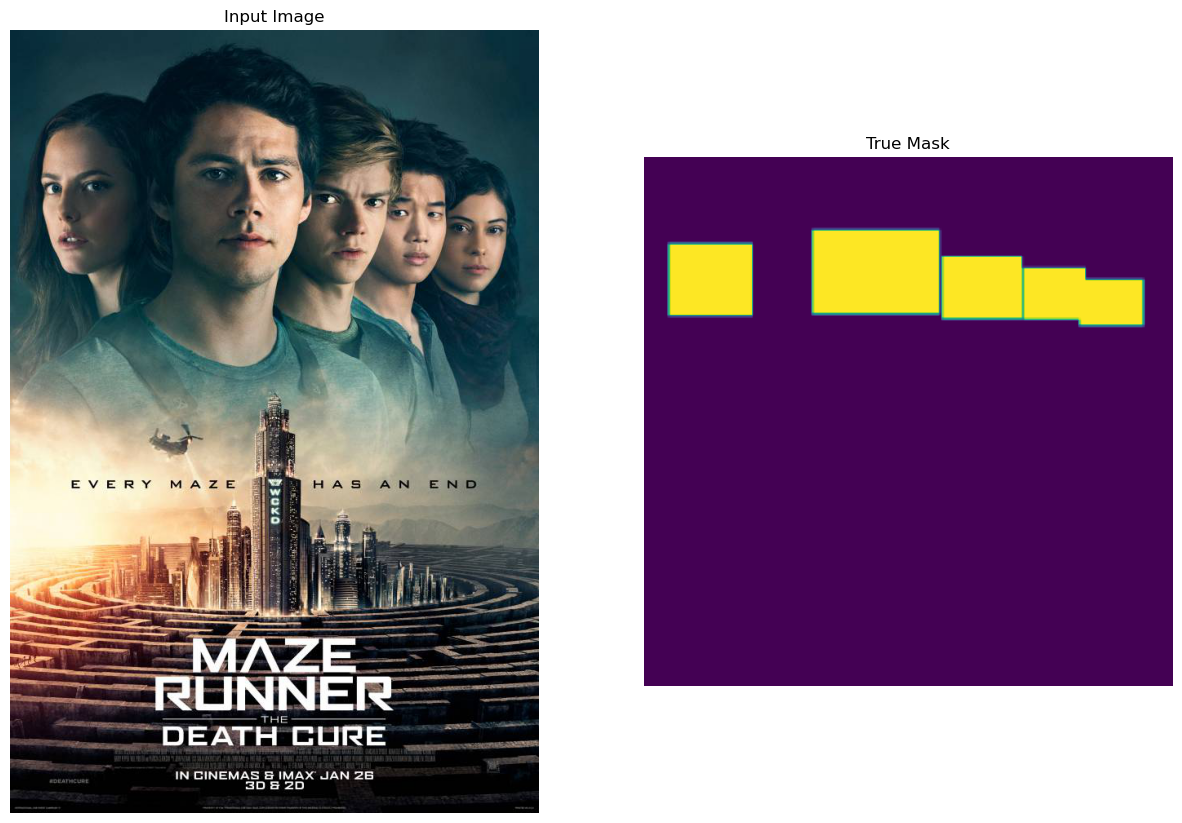

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

display([images[10], resized_masks[10]])

> Now, let's visualize the resized image. We have resized our images to 224 X 224 dimensions

In [61]:
def visualize_resizing(original_image, original_mask, resized_image, resized_mask, bounding_boxes):
    """
    Visualize the original and resized images/masks with bounding boxes.
    """
    #original_with_boxes = draw_bounding_boxes(original_image, bounding_boxes)
    #resized_image_with_boxes = draw_bounding_boxes(original_image, bounding_boxes)

    plt.figure(figsize = (15, 15))
    titles = ["Original Image", "Original Mask", "Resized Image", "Resized Mask"]
    images = [original_image, original_mask, resized_image, resized_mask]

    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.title(titles[i])
        cmap = 'YlGnBu_r' if i % 2 == 1 else None
        plt.imshow(images[i], cmap = cmap)
        #plt.axis('off')
    plt.show()


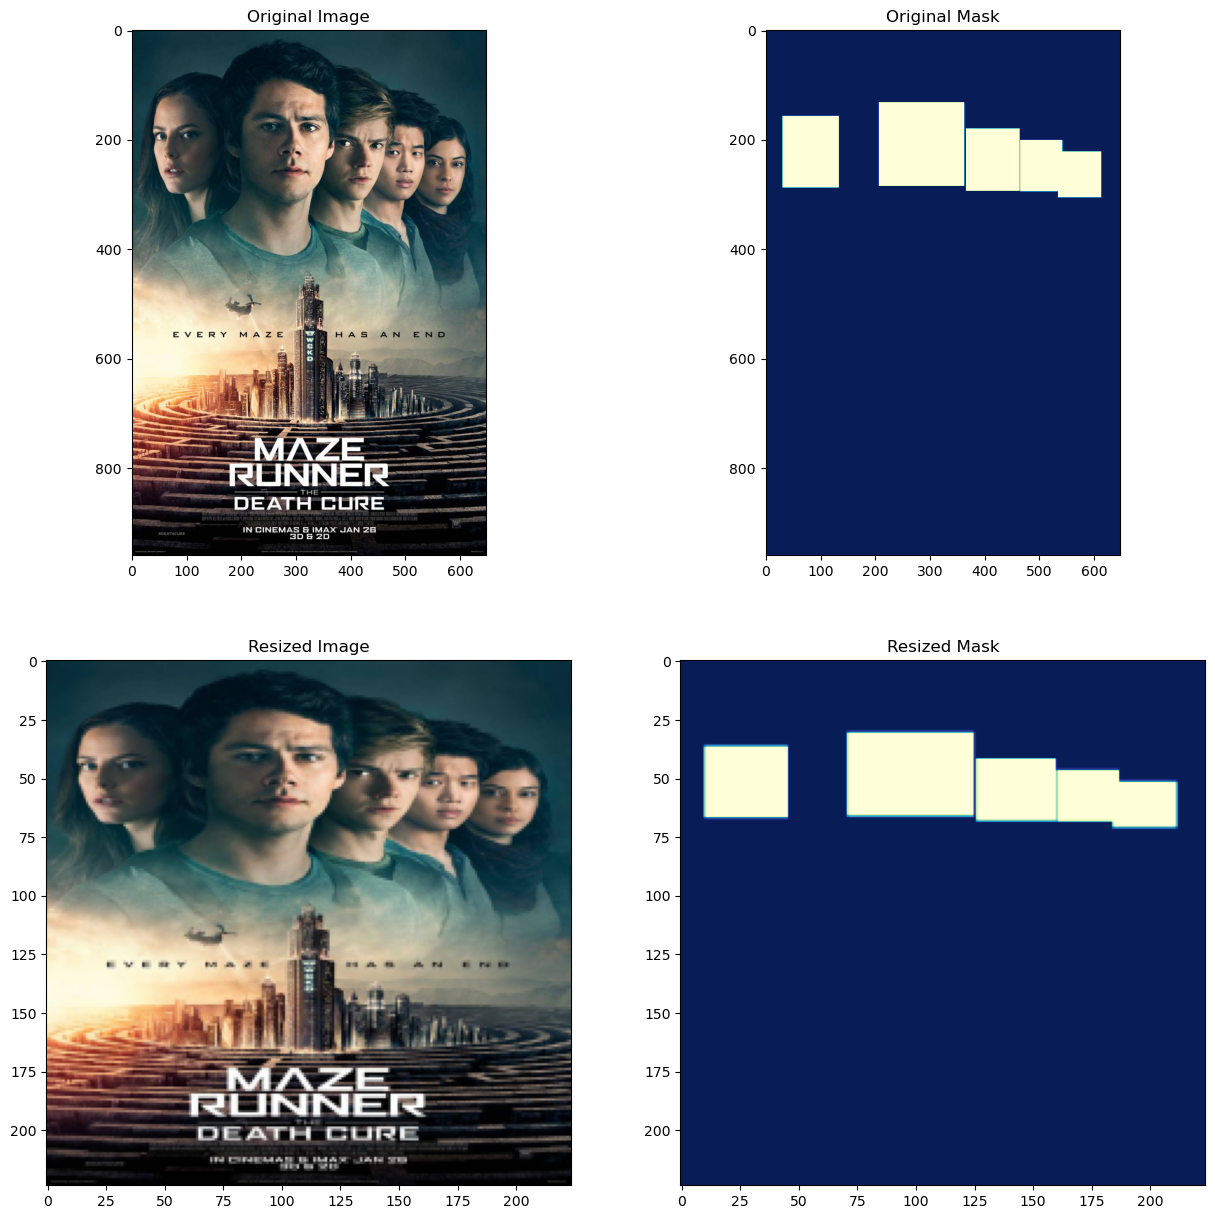

In [62]:
idx = 10
original_image = images[idx]
original_mask, bounding_boxes = generate_mask(masks[idx], (original_image.shape[0], original_image.shape[1]))
resized_image, resized_mask = resize_image_and_mask(original_image, original_mask, (TARGET_WIDTH, TARGET_HEIGHT))

visualize_resizing(original_image, original_mask, resized_image, resized_mask, bounding_boxes)

> As we see here, the resized image has reduced dimensions as compared to the original image in previous output. With this we can conclude that we have successfully resized our original images and scaled-down their respective dimensions to a consistent value of 244 X 244 and while keeping their originality in place with the same objects and annotations.
>
> This will also ensure that our transformations, if applied in future, are applied correctly and there is a uniform input to the neural network
> 
> Let's proceed with the next steps

### Split the data into train and test

> We will now split our data into training and testing sets where we will consider X as the images and y as their corresponding masks.
>
> Since there are no proportions specified, we will be splitting our data into a 80:20 proportion, means 80% of the data will be used for training, and 20% will be used for testing

In [18]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(resized_images, resized_masks, test_size = 0.2, random_state = 42)

In [19]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

# Printing the shapes of the train and test sets
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", y_train.shape)
print("Shape of Y_test:", y_test.shape)
# print("X_train: ", X_train)
# print("y_train: ", y_train)
# print("X_test: ", X_test)
# print("y_test: ", y_test)
print(f"\nImage range: {X_train.min()} to {X_train.max()}")
print(f"Mask range: {y_train.min()} to {y_train.max()}")

Number of training samples: 314
Number of testing samples: 79

Shape of X_train: (314, 224, 224, 3)
Shape of X_test: (79, 224, 224, 3)
Shape of Y_train: (314, 224, 224)
Shape of Y_test: (79, 224, 224)

Image range: 0 to 255
Mask range: 0 to 255


## <u>Model Building and Evaluation</u>

### Design a face mask detection model

> Given that our problem involves detecting one or more faces in a scene and determining if they have masks, U-Net is a better fit when compared to CNN, for the following reasons:
> * UNet’s architecture allows accurate segmentation of mask areas, offering accurate real-time identification and enhancing user experience such in our case
> * It can handle diverse movie scene variations such as different lighting conditions, and facial angles
> * It also provides easy-to-interpret bounding boxes and unlike traditional CNNs that focus solely on classifying images
> * UNet’s encoder-decoder structure ensures accurate mask localization making it a good choice
> 
> * UNet can be used to segment the face area covered by the mask in more detail and its pixel-level precision makes it ideal for detecting masks on faces
>
> Let's proceed with the implementation

<u>**Normalizing Train and Test Sets**
> As we have seen earlier that the images and masks range are 0 to 255, we would need to normalize them first as part of preprocessing step and ensure that our y_train and y_test are binary
>
> We would also expand the dimensions of our mask dataset to include the color scale so we can use it for U-Net input

In [20]:
X_train = np.array(X_train) / 255.0  # Normalize images
X_test = np.array(X_test) / 255.0

y_train = np.array(y_train) / 255.0
y_test = np.array(y_test) / 255.0

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (314, 224, 224, 3), (314, 224, 224, 1)
Testing data shape: (79, 224, 224, 3), (79, 224, 224, 1)


In [21]:
K.clear_session()

In [22]:
def conv_block(input_tensor, num_filters, dropout_rate=None):
    """
    A convolutional block consisting of two convolutional layers, with optional dropout.
    """
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    x = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)
    return x

def unet_model(input_size=(224, 224, 3), filters=64, dropout_rate=0.5, l2_lambda=0.001):
    inputs = layers.Input(input_size)

    # Encoder
    encoders = []
    x = inputs
    for i in range(4):
        x = conv_block(x, filters * (2 ** i), dropout_rate if i < 2 else None)  # Dropout for the first 2 blocks
        encoders.append(x)
        x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = conv_block(x, filters * 16)

    # Decoder
    for i in reversed(range(4)):
        x = layers.Conv2DTranspose(filters * (2 ** i), (3, 3), strides=(2, 2), padding='same')(x)
        x = layers.concatenate([encoders[i], x], axis=3)
        x = conv_block(x, filters * (2 ** i))

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    model.summary()

    return model


> Here we have created a method which takes the size of images as input and returns the U-Net model
> The model comprises of  sections
> 1. **Encoder Section:** This consists of Convolutional Layer, which applies 2D convolution with increasing filters (64 → 128 → 256 → 512) with each layer along with 'ReLu' activation function and MaxPooling layers which reduces the height and width by half after each convolution block
> 
> 2. **Bottleneck Section:** This one is the middle and most compressed layer and ing using 1024 filters. However, this layer is capturing the most data of the images
> 
> 3. **Decoder Section:** This section is responsible to deconvolute the layers. This uses Conv2DTranspose to restore the image size, Concatenate to retail all the dimensions of the images and Conv2D layers to refine the features after each restoration step
> 
> 4. The **Output layer** is creating a binary mask (0 or 1) with a 'Sigmoid' activation to indicate the presence or absence of the object (e.g., mask vs. no-mask)

In [23]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice Coefficient for segmentation evaluation.
    """
    # Convert to TensorFlow tensors (ensure dtype is float32)
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    
    # Flatten the arrays using tf.reshape
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Compute intersection
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """
    Compute the Dice loss.
    """
    return 1 - dice_coefficient(y_true, y_pred)


> After the model building, we have now created the methods for Dice Coefficient & Dice Loss.
>
> The **dice_coefficient** method computes the dice coefficient which is used to evaluate image segmentation models. It takes the y_true (true data) and y_pred (predicted data) as inputs and flattens them to a 1D array to efficiently compute the coefficient value and outputs a value between 0 and 1, where 1 means perfect overlap
>
> Similarly, the **dice_loss** computes the complement of the dice coefficient and will be used as a loss function and helps minimise the difference between the predicted and true masks during training 

<u>**Defining and Summarizing the U-Net Model**

> We'll print the model summary here.
>   * It shows how our U-Net model is constructed layer by layer, with each layer utilizing multiple convolutional, dropout, and max-pooling layers for downsampling and symmetric transpose convolutions with skip connections for upsampling
>   * It used a functional Keras API to connect the layers
>   * It also gives the name and type of layer, the shape of the data as it leaves the layer, and the number of trainable parameters in that layer

In [24]:
model = unet_model(input_size = (TARGET_HEIGHT, TARGET_WIDTH, 3))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 224, 224,  │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 112, 112,  │          0 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14,    │  9,438,208 │ conv2d_8[0][0]  

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

### Evaluate and Share Insights on performance of the model

> To evaluate the model, we will first compile it with appropriate optimizer and then we will train the model using callbacks like early stopping and learning rate reduction to make the model efficient

<u>**Compiling the U-Net Model**</u>
    
> * We will be using the **Adam optimizer**, to adapt the learning rate during training for faster convergence 
> * **dice_loss** and **dice_coefficient** to check similarity and differences in true and predicted value

In [25]:
# Compile the model
model.compile(optimizer = 'adam', loss = dice_loss, metrics = [dice_coefficient])

<u>**Fit the U-Net Model**

In [26]:
# To stop training if no improvement
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

# To reduce learning rate
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 1e-6)

> We have used **Early stopping** to stop training if no improvement is seen in validation loss and **lr_reduction** to reduce learning rate when validation loss stops improving

In [27]:
# Fit the model with the training data
start_time = time.time()
history = model.fit(X_train, y_train, 
                    epochs = 20, batch_size = 16, 
                    validation_data = (X_test, y_test),
                    callbacks = [early_stopping, lr_reduction]
                   )
end_time = time.time()

total_time = (end_time - start_time)
print(f"Total time to train the model: {total_time /3600:.2f} hours")

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1136s 56s/step - dice_coefficient: 0.2046 - loss: 0.7955 - val_dice_coefficient: 0.2420 - val_loss: 0.7581 - learning_rate: 0.0010
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1138s 55s/step - dice_coefficient: 0.2259 - loss: 0.7741 - val_dice_coefficient: 0.2422 - val_loss: 0.7580 - learning_rate: 0.0010
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1096s 55s/step - dice_coefficient: 0.2409 - loss: 0.7592 - val_dice_coefficient: 0.3035 - val_loss: 0.6967 - learning_rate: 0.0010
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1100s 55s/step - dice_coefficient: 0.2741 - loss: 0.7259 - val_dice_coefficient: 0.4133 - val_loss: 0.5867 - learning_rate: 0.0010
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1112s 56s/step - dice_coefficient: 0.3406 - loss: 0.6595 - val_dice_coefficient: 0.4155 - val_loss: 0.5845 - learning_rate: 0.0010
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1150s 55s/step - dice_coefficient: 0.3658 - loss: 0.6340 - val_dice_coefficient: 0.4115 - val_loss: 0.5885 - learning

> The model took around 5 hours to get trained and stopped with a maintainable learning rate of 0.0005.
>
> Our model did not stop earlier even though it is seen to be constant in terms of validation loss and validation dice coefficient because in our early_stopping variable, the patience level is set to 10 which means the training stops when val_loss does not improve for 10 consecutive epochs. However, it seems the val_loss remains stagnant at 0.7587 after epoch 10, and by the time the all the epoch processing ends, we almost reached the limit and it only had chance to stop at the second last, i.e., the 19th epoch where it did.
>
> The validation dice coefficient also looks to be constant after the 10th epoch

<u>**Detailed Insights on Model performance**

In [28]:
start_time = time.time()

# Convert the true values (y_train and y_test) into binary format
y_train_bin = (y_train > 0.5).astype(int)
y_test_bin = (y_test > 0.5).astype(int)

y_test_bin = y_test_bin.astype('float32')
y_train_bin = y_train_bin.astype('float32')

# Evaluate on the train set
train_preds = model.predict(X_train)
train_preds = (train_preds > 0.5).astype(int)  # Convert predictions to binary (0 or 1)

# Calculate train metrics
train_accuracy = accuracy_score(y_train_bin.flatten(), train_preds.flatten())
train_precision = precision_score(y_train_bin.flatten(), train_preds.flatten(), average='binary')
train_recall = recall_score(y_train_bin.flatten(), train_preds.flatten(), average='binary')
train_f1 = f1_score(y_train_bin.flatten(), train_preds.flatten(), average='binary')
train_dice = dice_coefficient(y_train_bin, train_preds) 

# Calculate train loss
train_loss = model.evaluate(X_train, y_train_bin, verbose=0)[0]  

# Evaluate on the test set
test_preds = model.predict(X_test)
test_preds = (test_preds > 0.5).astype(int)  # Convert predictions to binary (0 or 1)

# Calculate test metrics
test_accuracy = accuracy_score(y_test_bin.flatten(), test_preds.flatten())
test_precision = precision_score(y_test_bin.flatten(), test_preds.flatten(), average='binary')
test_recall = recall_score(y_test_bin.flatten(), test_preds.flatten(), average='binary')
test_f1 = f1_score(y_test_bin.flatten(), test_preds.flatten(), average='binary')
test_dice = dice_coefficient(y_test_bin, test_preds) 

# Calculate test loss
test_loss = model.evaluate(X_test, y_test_bin, verbose=0)[0]  

# Organize the output
output_data = {
    "Metrics": ["Accuracy", "Precision", "Recall", "F1 Score", "Dice Coefficient", "Loss"],
    "Train Set": [
        format(train_accuracy, '.3f'),
        format(train_precision, '.3f'),
        format(train_recall, '.3f'),
        format(train_f1, '.3f'),
        format(train_dice, '.3f'),
        format(train_loss, '.3f')  
    ],
    "Test Set": [
        format(test_accuracy, '.3f'),
        format(test_precision, '.3f'),
        format(test_recall, '.3f'),
        format(test_f1, '.3f'),
        format(test_dice, '.3f'),
        format(test_loss, '.3f')  
    ]
}

end_time = time.time()

total_time = (end_time - start_time)
print(f"Total time to Compute the Evaluation Metrics: {total_time /60:.2f} minutes")

# Convert to DataFrame
output_df = pd.DataFrame(output_data)

# Display the results
output_df


10/10 ━━━━━━━━━━━━━━━━━━━━ 244s 24s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 63s 18s/step
Total time to Compute the Evaluation Metrics: 12.09 minutes


Metrics Train Set Test Set
0          Accuracy     0.814    0.805
1         Precision     0.336    0.361
2            Recall     0.483    0.542
3          F1 Score     0.396    0.433
4  Dice Coefficient     0.396    0.433
5              Loss     0.608    0.568

> Our model performance indicates a moderate performance of our trained model with strengths in recall but challenges in precision and overall accuracy. Let's have a more detailed insight:
>  1. **Model Metrics Overview:**
>      * Our model shows an overall **accuracy** of more than 80% for both the training and test sets, meaning it correctly predicts labels about 80% of the time. While there's room for enhancement, this provides a solid foundation to build upon and improve upon in future iterations and reflects a robust foundation with minimal overfitting, as there is close alignment between training and test accuracy
>      * **Precision** on the test set is less, however it is an improvement over the training precision and indicates that the model can make slightly more accurate positive predictions on unseen data
>      * **Recall** is a notable strength for our model. This highlights that our model is doing well in capturing most positive instances and is sensitive to identifying positive cases which is a key factor for our problem statement
>      * The **F1 score** and **Dice coefficient** on the test set are similar and reflect a balanced performance, with the model showing slight improvement on the test set compared to the training set
>      * **Loss values** for training and testing sets are closely aligned, which is a good sign that our model isn't overfitting that much and can generalize well to new data
>      * Though, there is room to fine-tune our model to help capture more intricate patterns and improve overall performance, it also shows a positive sign to identifying true cases
> 
>
>  2. Our model has a good recall and is effective in detecting most instances which are critical for ensuring no cast members are missed in a scene. However, there is a work which can be done on reducing false positives to enhance user trust and engagement
>  
>  3. We could also refine F1 score and Dice coefficient to make our model more robust and useful, striking the right balance between not missing relevant scenes and avoiding irrelevant or incorrect data
>  
>  4. As we have seen that our model is mostly imbalanced with the masks set having only the positive cases. This creates an impression to the trained model of only detecting the positive cases, reducing it's overall accuracy. Though sampling techniques can be applied, those only create imaginary data which is not close to reality increasing the chances of reduced accuracy in some cases. As Business, there should be a proper dataset to include false cases as well equally so the model is trained well on a balanced dataset

In [29]:
print("X_train shape:", X_test.shape)
print("y_train_bin shape:", y_test_bin.shape)
print("X_train dtype:", X_test.dtype)
print("y_train_bin dtype:", y_test_bin.dtype)

X_train shape: (79, 224, 224, 3)
y_train_bin shape: (79, 224, 224, 1)
X_train dtype: float64
y_train_bin dtype: float32


### Predict and visualize the masks for the test images

<u>**Predict the Model**

In [30]:
# To make predictions on test images
predictions = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 17s/step


> Now that we have predicted the values of our test dataset, let's proceed to visualize it for a test image

<u>**Visualize the Masks**

> We will be creating a method which takes the images set as input and predicts the actual and masked images

In [31]:
# Methods to visualize predictions
def plot_image(ax, img, title, cmap = None):
    ax.imshow(img, cmap = cmap)
    ax.set_title(title)
    ax.axis('off')

def visualize_predictions(images, true_masks, predicted_masks, idx):
    fig, axes = plt.subplots(1, 3, figsize = (15, 15))

    plot_image(axes[0], images[idx], "Input Image")
    plot_image(axes[1], true_masks[idx], "True Mask", cmap = "gray")
    plot_image(axes[2], predicted_masks[idx], "Predicted Mask", cmap = "gray")

    plt.show()

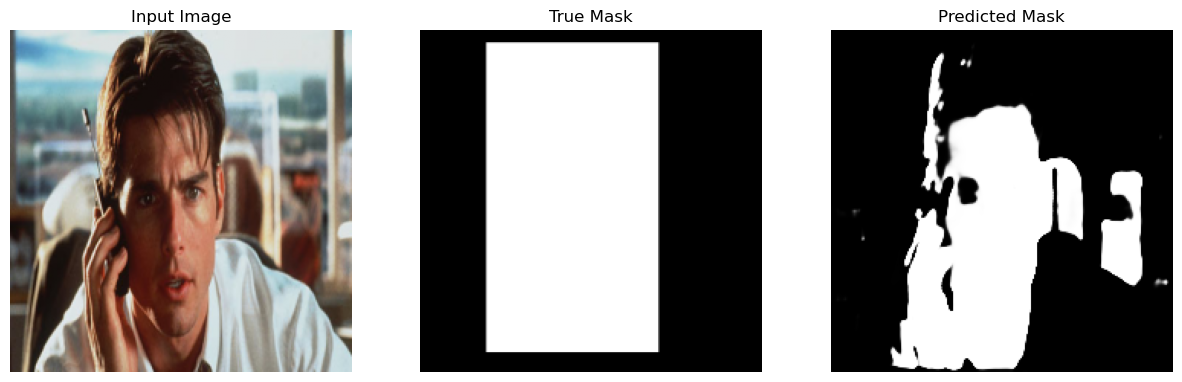

In [32]:
# Visualize a prediction
visualize_predictions(X_test, y_test, predictions, idx = 2)

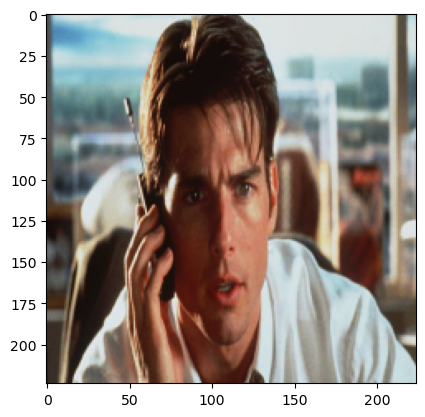

In [33]:
m = 2
plt.imshow(X_test[m])

In [34]:
pred_mask = cv2.resize(1.0 * (model.predict(x=np.array([X_test[m]]))[0] > 0.9), (TARGET_WIDTH, TARGET_HEIGHT)) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


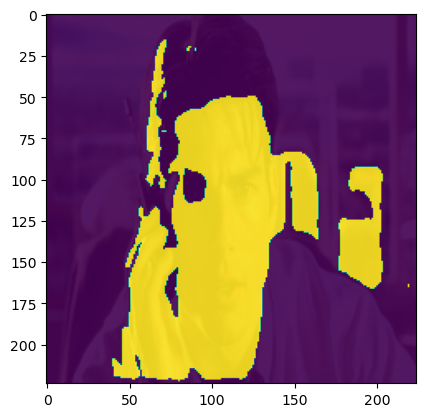

In [35]:
plt.imshow(X_test[m])
plt.imshow(pred_mask, alpha=0.9)

> Here we see that our model is able to predict the masks somewhat accurately and is able to capture the face area.
>
> Though there are slight variations on other components being captured, it is able to positively and accurately able to capture the face area. The other sections captured are probably due to lower accuracy of our model due to highly imbalanced data and can be improved further by using below suggestions:
> * Hypertuning the parameters of our U-Net model to get the optimal parameters for our use
> * Balancing the data using balancing techniques like over or under sampling. We could use over-sampling in our case as doing under sampling will remove most of the actual positive cases which is not recommended specially in this case of high imbalance towards 1 set
>
> Above are just recommendations which can be done further however, as per the ask in the questions, we are not moving forward to implement these areas

## <u>Predicting Face Masks from Images</u>

### Import Images from folder ‘training_images’

In [36]:
zip_file_path = 'C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 9 - Computer Vision (Week 32 to Week 37)/Project/Datasets/training_images-20211126T092819Z-001.zip'
extracted_folder = 'C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 9 - Computer Vision (Week 32 to Week 37)/Project/Datasets/training_images'

In [37]:
os.makedirs(extracted_folder, exist_ok=True)

with ZipFile(zip_file_path, 'r') as z:
    for member in z.namelist():
        try:
            target_path = os.path.join(extracted_folder, member.replace(" ", "_"))  # Replace spaces in filenames
            if member.endswith('/'):  # If it's a directory
                os.makedirs(target_path, exist_ok=True)
            else:  # If it's a file, extract it
                os.makedirs(os.path.dirname(target_path), exist_ok=True)
                with z.open(member) as source, open(target_path, 'wb') as target:
                    target.write(source.read())
        except Exception as e:
            print(f"Failed to extract {member}: {e}")
print("\"training_images\" zip folder extraction done with path handling!")

"training_images" zip folder extraction done with path handling!


> Here we have used os's makedirs function to ensure the target extraction folder is created if it doesn't already exist, handling the case where it may already be present without raising an error with "exist_ok=True"

### Detect faces, extract metadata for the faces in all the images, and write and save it into a DataFrame

> We will be creating a code that iterates over all the image files in the extyracted directory, load them with **face_recognition** and then collect metadata, including coordinates and dimensions, for faces found in each image

In [41]:
image_dir = Path(extracted_folder) / 'training_images'

metadata = []
# Loop through all the images in the directory
for file_name in os.listdir(image_dir):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
        image_path = os.path.join(image_dir, file_name)

        # Load the image using face_recognition
        # print(f"Processing {i + 1}: {file_name}...")  # Progress indicator
        try:
            image = face_recognition.load_image_file(image_path)
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            continue

        # Detect face locations
        face_locations = face_recognition.face_locations(image)

        if face_locations:  # If faces are detected
            # Add metadata for each detected face
            for top, right, bottom, left in face_locations:
                metadata.append({
                    "file_name": file_name,
                    "top": top,
                    "right": right,
                    "bottom": bottom,
                    "left": left,
                    "width": right - left,
                    "height": bottom - top
                })

> Now that the metadata  dataset is created with all the required data and columns named file_name,top, right, bottom, left, width, and height, we will save it to a dataframe and also output it to a CSV file for any further usages

In [42]:
# Save metadata to a CSV file
df = pd.DataFrame(metadata)
output_csv_path = 'C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 9 - Computer Vision (Week 32 to Week 37)/Project/Datasets/faces_metadata.csv'
df.to_csv(output_csv_path, index=False)

print(f"Metadata saved to {output_csv_path}")


Metadata saved to C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 9 - Computer Vision (Week 32 to Week 37)/Project/Datasets/faces_metadata.csv


In [43]:
df.head()

file_name  top  right  bottom  left  width  height
0  real_00001.jpg  162    546     547   161    385     385
1  real_00002.jpg  204    504     590   118    386     386
2  real_00003.jpg  119    418     504    33    385     385
3  real_00004.jpg  206    455     527   134    321     321
4  real_00005.jpg  162    418     547    33    385     385

> Now, let's visualize random 5 images out of the extracted metadata dataset and draw bounding boxes on them

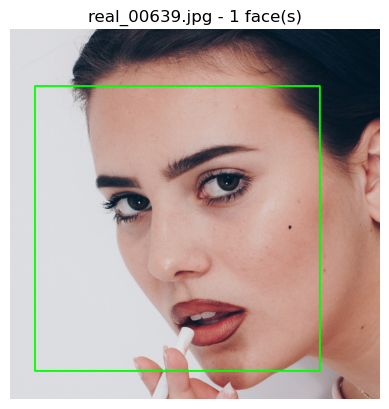

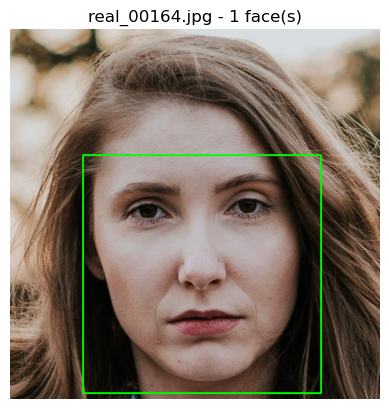

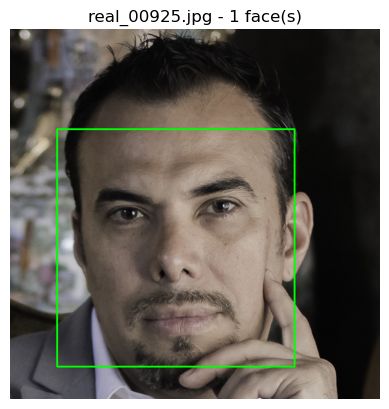

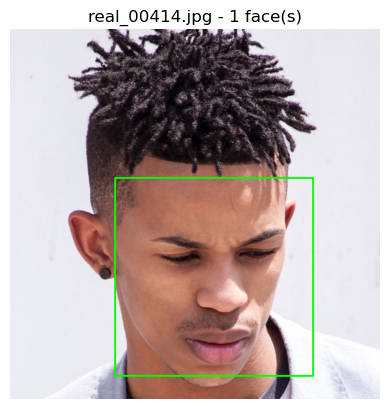

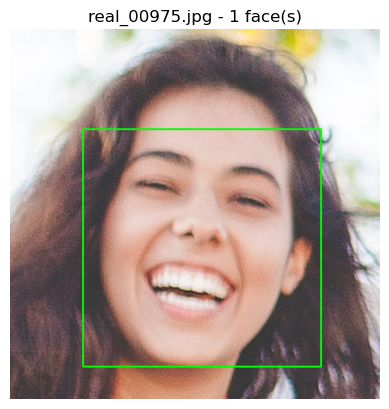

In [44]:
# To visualize only 5 random images
random_images = random.sample([f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))], 5)

# Display a random set of 5 images
for file_name in random_images:
    image_path = os.path.join(image_dir, file_name)
    
    # Load the image using face_recognition
    image = face_recognition.load_image_file(image_path)
    
    # Detect face locations
    face_locations = face_recognition.face_locations(image)
    
    # Convert image to BGR (OpenCV format) to draw rectangles
    cv2_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Draw bounding boxes around faces
    for top, right, bottom, left in face_locations:
        cv2.rectangle(cv2_image, (left, top), (right, bottom), (0, 255, 0), 2)
    
    # Display image with bounding boxes
    plt.imshow(cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB))
    plt.title(f"{file_name} - {len(face_locations)} face(s)")
    plt.axis("off")
    plt.show()


***
***
# <u>PART B</u>
***

## <u>Data Preprocessing</u>

### Import the Data


In [45]:

zip_file_path = 'C:/Users/pri96/OneDrive/Desktop/PINS.zip' 
extraction_path = 'C:/Users/pri96/OneDrive/Desktop/PINS_extracted/'
# Ensure extraction path exists
os.makedirs(extraction_path, exist_ok=True)

# Extract the ZIP file with path handling
with ZipFile(zip_file_path, 'r') as z:
    for member in z.namelist():
        try:
            # Create the target path
            target_path = os.path.join(extraction_path, member.replace(" ", "_"))  # Replace spaces
            if member.endswith('/'):
                # If it's a directory, create it
                os.makedirs(target_path, exist_ok=True)
            else:
                # If it's a file, create the directory first
                os.makedirs(os.path.dirname(target_path), exist_ok=True)
                # Extract the file
                with z.open(member) as source, open(target_path, 'wb') as target:
                    target.write(source.read())
        except Exception as e:
            print(f"Failed to extract {member}: {e}")

print("Training zip extraction done with path handling!")

Training zip extraction done with path handling!


> We have imported the data with path error handling as we faced multipel errors while file extraction where the code was not able to find a few paths due to some issues. With path error handling, we are able to successfully extract the data
>
> We will now proceed with next steps

### Read the Images and Extract Labels from the FileNames for all the Folders

<u>**Reading the Extracted Images**

> We will loop through all subdirectories to locate the images
>
> Also, to avoid missing any images due to format, we are adding multiple image extensions as list 

In [46]:
# Define the dataset directory
dataset_path = Path(extraction_path) / 'PINS' 

# Get all subdirectories (each representing a label)
actor_directories = [d for d in dataset_path.iterdir() if d.is_dir()]

print(f"Number of actor directories (labels): {len(actor_directories)}")

Number of actor directories (labels): 196


<u>**Extract Labels from File Names**</u>

> We will be extracting subdirectory name (e.g., pins_Natalie_Portman) as the label for all images within that subdirectory
>
> For that, we will be first separating out the images and their labels in different datasets and then extracting only the metadata, i.e., the file_name, file_size, height, width and the label name.
>
> We will then store it in a dataframe for further use, if required

In [47]:
# Initialize lists to store image paths and labels
image_paths = []
labels = []

# List of supported image extensions
image_extensions = ["*.jpg", "*.jpeg"]  

# Loop through each actor's directory
for actor_dir in actor_directories:
    actor_label = actor_dir.stem  # Use the folder name as the label
    for ext in image_extensions:
        for image_file in actor_dir.glob(ext):  # Loop through all specified extensions
            image_paths.append(str(image_file))
            labels.append(actor_label)

# Display dataset summary
print(f"Total Number of Images Processed: {len(image_paths)}")
print(f"Unique Labels (Number of distinct subdirectories): {len(actor_directories)}")
print("Sample Labels (First five extracted labels):", labels[:5])
print("Sample Image Path (First file path to confirm that images are being read correctly):", image_paths[0])

Total Number of Images Processed: 18800
Unique Labels (Number of distinct subdirectories): 196
Sample Labels (First five extracted labels): ['pins_Aaron Paul', 'pins_Aaron Paul', 'pins_Aaron Paul', 'pins_Aaron Paul', 'pins_Aaron Paul']
Sample Image Path (First file path to confirm that images are being read correctly): C:\Users\pri96\OneDrive\Desktop\PINS_extracted\PINS\pins_Aaron Paul\Aaron Paul0_262.jpg


> Let's check a few images

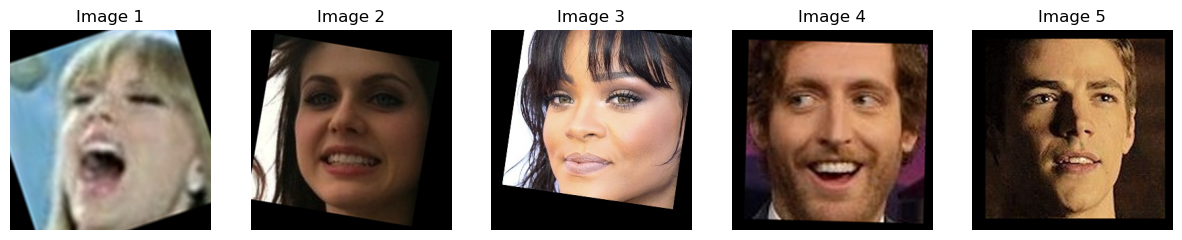

In [48]:

def show_random_images(image_paths, num_images=5):
    """
    Function to display a few random images from the image_paths list.
    
    Parameters:
    - image_paths: List of image file paths
    - num_images: Number of random images to display
    """
    # Shuffle the image_paths list to randomize the order
    random.shuffle(image_paths)
    
    # Select a random sample of images
    random_images = random.sample(image_paths, num_images)
    
    # Plot the images
    plt.figure(figsize=(15, 10))
    
    for i, img_path in enumerate(random_images):
        # Load the image
        img = load_img(img_path)
        
        # Create a subplot for each image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')  # Hide the axes for a cleaner look
        plt.title(f"Image {i + 1}")
    
    plt.show()

# Display 5 random images from the dataset
show_random_images(image_paths, num_images=5)


> Now that we have visualized a few images, let's go on and extract the data and divide into columns to save in a dataframe

In [49]:

def extract_metadata(image_paths, num_images=5):
    """Extracts metadata for a set of random images."""
    try:
        # Randomly sample a specified number of image paths
        random_images = random.sample(image_paths, num_images)

        metadata_list = []  # List to store metadata for each image
        for image_path in random_images:
            # Get file size
            file_size = os.path.getsize(image_path)

            # Open image to get dimensions
            with Image.open(image_path) as img:
                width, height = img.size

            # Extract file name and label
            file_name = os.path.basename(image_path)
            label = os.path.basename(os.path.dirname(image_path)) 

            # Collect metadata as a dictionary
            metadata_list.append({
                'file_name': file_name,
                'file_size': file_size,
                'width': width,
                'height': height,
                'label': label
            })

        # Return the list of metadata dictionaries
        return metadata_list

    except Exception as e:
        print(f"Error processing images: {e}")
        return None

metadata = extract_metadata(image_paths, 3)
print(metadata)


[{'file_name': 'Betsy_Brandt147_418.jpg', 'file_size': 13161, 'width': 299, 'height': 299, 'label': 'pins_Betsy_Brandt'}, {'file_name': 'Neil_Patrick_Harris31.jpg', 'file_size': 22648, 'width': 299, 'height': 299, 'label': 'pins_Neil_Patrick_Harris'}, {'file_name': 'Jesse_Eisenberg51_1428.jpg', 'file_size': 16965, 'width': 299, 'height': 299, 'label': 'pins_Jesse_Eisenberg'}]


In [50]:
def extract_metadata_for_single_image(file_path):
    """Extract metadata for a single image."""
    try:
        if not file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            return None

        # Get file size
        file_size = os.path.getsize(file_path)

        # Open image to get dimensions
        with Image.open(file_path) as img:
            width, height = img.size

        # Extract file name and label (folder name)
        file_name = os.path.basename(file_path)
        label = os.path.basename(os.path.dirname(file_path))

        return {
            "file_name": file_name,
            "file_size": file_size,
            "width": width,
            "height": height,
            "label": label,
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    
def create_metadata_for_all_images(directory_path):
    """Iterates over the directory, extracts metadata for all images, and stores it in a DataFrame."""
    metadata_list = []

    for actor_folder in os.listdir(directory_path):
        actor_folder_path = os.path.join(directory_path, actor_folder)
        
        # Skip non-directories and system folders like __MACOSX to avoid confusion
        if not os.path.isdir(actor_folder_path) or actor_folder.startswith('__'):
            continue

        #print(f"Processing folder: {actor_folder_path}")
        image_files = [
            f for f in os.listdir(actor_folder_path)
            if os.path.isfile(os.path.join(actor_folder_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        
        if not image_files:
            print(f"Warning: No valid image files found in {actor_folder_path}.")
            continue
        
        for file in image_files:
            file_path = os.path.join(actor_folder_path, file)
            #print(f"Processing file: {file_path}")
            metadata = extract_metadata_for_single_image(file_path)
            if metadata:
                metadata_list.append(metadata)

    if not metadata_list:
        print("No valid images processed.")
        return pd.DataFrame()  # Return empty DataFrame if no data is collected

    return pd.DataFrame(metadata_list)

# Example usage
extraction_path = r"C:/Users/pri96/OneDrive/Desktop/PINS_extracted/PINS"
metadata_df = create_metadata_for_all_images(extraction_path)

print("\n The extracted metadata has", metadata_df.shape[0], "rows and", metadata_df.shape[1], "columns")
print("\n Few records from the extracted metadata - ")
metadata_df.sample(10, random_state = 42)


 The extracted metadata has 18800 rows and 5 columns

 Few records from the extracted metadata - 


file_name  file_size  width  height  \
13755  Neil_Patrick_Harris13.jpg      22137    299     299   
13306      Morena Baccarin99.jpg      23719    299     299   
10098          Jim Parsons94.jpg      16144    299     299   
6879     Emilia Clarke50_952.jpg      32590    299     339   
13862            Paul Rudd19.jpg      33846    299     297   
7327            Emma Stone74.jpg      20241    299     299   
13397      Morena_Baccarin60.jpg      19322    299     299   
9618         Jeremy Renner33.jpg      16315    299     299   
1297      amber heard face76.jpg      21726    299     299   
42         Aaron Paul191_269.jpg      23900    299     299   

                          label  
13755  pins_Neil_Patrick_Harris  
13306      pins_Morena Baccarin  
10098          pins_Jim Parsons  
6879         pins_Emilia Clarke  
13862            pins_Paul Rudd  
7327            pins_Emma Stone  
13397      pins_Morena_Baccarin  
9618         pins_Jeremy Renner  
1297      pins_amber heard face  
42              pins_Aaron Paul

## <u>Visualizing Similar Images</u>

### Generate embedding vectors for each image in the dataset


> We will use the pre-trained VGG16 model to extract feature embeddings from images as it simplifies tasks like similarity analysis, clustering, etc. which is what we want here. It is also extensively tested and widely supported in deep learning frameworks, ensuring reliable performance and community support
>
> * After loading VGG16, we will modify it to exclude its final classification layer, allowing us to retrieve meaningful feature vectors instead of final predictions
> * We will also resize our images to 224x224, convert to arrays, and preprocess them to align with VGG16 input requirements
> * The model will then extract embeddings from the fc1 layer, capturing high-level visual features for each image
> * We will then generate the embedding for each image and return the combined finished embeddings
>
> Overall, VGG16 is a proven, versatile model with consistent performance, and its embeddings capture rich, transferable features ideal for many image-related tasks like in our case

In [51]:
# Load the VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet')
# Remove the classification layer to extract feature embeddings
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

print("VGG16 model loaded and configured for feature extraction.")

VGG16 model loaded and configured for feature extraction.


In [52]:
def generate_embeddings(image_paths, model):
    """
    Generate embeddings for all images using a pre-trained model.

    Parameters:
    - image_paths: List of paths to the images.
    - model: Pre-trained model for feature extraction. VGG16 in our case

    Returns:
    - embeddings: generated embeddings
    """
    embeddings = {}

    image_number = 1
    for img_path in image_paths:
        try:
            # Load and preprocess the image
            img = load_img(img_path, target_size=(224, 224))  # Resize image to 224x224
            img_array = img_to_array(img)  # Convert to numpy array
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
            img_array = preprocess_input(img_array)  # Preprocess for VGG16

            # Generate the embedding
            print("Predicting image", image_number, "of", metadata_df.shape[0])
            embedding = model.predict(img_array)[0]  # Get the feature vector
            embeddings[img_path] = embedding

            image_number += 1
            
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    
    return embeddings

start_time = time.time()
# Generate embeddings for all images
image_embeddings = generate_embeddings(image_paths, model)
end_time = time.time()

total_time = (end_time - start_time)

print(f"\n\nGenerated embeddings for {len(image_embeddings)} images.")
print(f"\n\nTotal time to Generate Embeddings: {total_time /60:.2f} minutes")


Predicting image 1 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicting image 2 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Predicting image 3 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Predicting image 4 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Predicting image 5 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 6 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 7 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 8 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 9 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 10 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 11 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 12 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 13 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 14 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 15 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 162 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 163 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 164 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 165 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
Predicting image 166 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 167 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 168 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 169 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 170 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 171 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 172 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 173 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 174 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 175 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 320 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 321 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 322 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 323 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 324 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 325 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 326 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 327 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 328 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 329 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 330 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 331 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
Predicting image 332 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 333 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 478 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 479 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 480 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step
Predicting image 481 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 482 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 483 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 484 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 485 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 486 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 487 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 488 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 489 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 490 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 491 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 636 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 637 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 638 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 639 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 640 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 641 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 642 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 643 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 644 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 645 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 646 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 647 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 648 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 649 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 794 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 795 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 796 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 797 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 798 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 799 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicting image 800 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicting image 801 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 802 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 803 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 804 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 805 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 806 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 807 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 952 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 953 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
Predicting image 954 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicting image 955 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 956 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 957 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 958 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 959 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 960 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 961 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 962 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 963 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 964 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 965 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 1110 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 1111 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 1112 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 1113 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 1114 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 1115 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 1116 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicting image 1117 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 1118 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 1119 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 1120 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 1121 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 1122 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 1123 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
Predicting image 1189 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Predicting image 1190 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
Predicting image 1191 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 1192 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
Predicting image 1193 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
Predicting image 1194 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
Predicting image 1195 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Predicting image 1196 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 1197 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 1198 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 1199 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Predicting image 1200 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Predicting image 1201 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 1202 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
Predicting image 1268 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 1269 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
Predicting image 1270 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicting image 1271 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 1272 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 1273 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 1274 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 1275 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 1276 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 1277 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 1278 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 1279 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
Predicting image 1280 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Predicting image 1281 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
Predicting image 1347 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
Predicting image 1348 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Predicting image 1349 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 1350 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 1351 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Predicting image 1352 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 1353 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 1354 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 1355 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 1356 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 1357 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
Predicting image 1358 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 1359 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Predicting image 1360 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 1426 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 1427 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 1428 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 1429 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 1430 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 1431 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 1432 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 1433 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 1434 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 1435 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 1436 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 1437 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 1438 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 1439 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 1505 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 1506 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
Predicting image 1507 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 1508 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 1509 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 1510 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 1511 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 1512 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 1513 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 1514 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
Predicting image 1515 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 1516 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Predicting image 1517 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 1518 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 1584 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
Predicting image 1585 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
Predicting image 1586 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
Predicting image 1587 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicting image 1588 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 1589 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 1590 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 1591 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 1592 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 1593 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 1594 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 1595 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 1596 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 1597 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 1663 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 1664 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 1665 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 1666 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 1667 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
Predicting image 1668 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
Predicting image 1669 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
Predicting image 1670 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 1671 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
Predicting image 1672 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
Predicting image 1673 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 1674 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
Predicting image 1675 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
Predicting image 1676 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 1742 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
Predicting image 1743 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicting image 1744 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
Predicting image 1745 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
Predicting image 1746 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 1747 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
Predicting image 1748 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 1749 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 1750 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 1751 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 1752 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 1753 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
Predicting image 1754 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 1755 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 1821 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 1822 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 1823 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
Predicting image 1824 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 1825 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 1826 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 1827 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 1828 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
Predicting image 1829 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 1830 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 1831 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 1832 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
Predicting image 1833 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 1834 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 1900 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 1901 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 1902 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 1903 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 1904 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 1905 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 1906 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 1907 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 1908 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 1909 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 1910 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 1911 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 1912 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
Predicting image 1913 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 1979 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 1980 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 1981 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 1982 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 1983 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 1984 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 1985 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 1986 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 1987 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 1988 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 1989 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 1990 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting image 1991 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 1992 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 2058 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 2059 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 2060 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 2061 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 2062 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 2063 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 2064 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 2065 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 2066 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 2067 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 2068 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 2069 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 2070 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 2071 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 2137 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 2138 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 2139 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 2140 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 2141 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 2142 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 2143 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 2144 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicting image 2145 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 2146 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 2147 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 2148 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 2149 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 2150 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 2216 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 2217 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 2218 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 2219 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 2220 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 2221 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicting image 2222 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 2223 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 2224 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 2225 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 2226 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 2227 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 2228 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 2229 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 2295 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicting image 2296 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 2297 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 2298 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 2299 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 2300 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 2301 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 2302 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 2303 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 2304 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 2305 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 2306 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 2307 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Predicting image 2308 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 2374 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 2375 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 2376 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 2377 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 2378 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 2379 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 2380 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 2381 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Predicting image 2382 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 2383 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 2384 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 2385 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 2386 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 2387 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 2453 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 2454 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 2455 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 2456 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 2457 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 2458 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 2459 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 2460 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 2461 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 2462 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 2463 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 2464 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
Predicting image 2465 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 2466 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 2532 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 2533 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 2534 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 2535 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 2536 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 2537 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 2538 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
Predicting image 2539 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 2540 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 2541 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 2542 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 2543 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 2544 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 2545 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 2611 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 2612 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 2613 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 2614 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 2615 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 2616 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 2617 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 2618 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 2619 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 2620 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 2621 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 2622 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 2623 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 2624 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 2690 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 2691 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 2692 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 2693 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 2694 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 2695 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 2696 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 2697 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 2698 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 2699 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 2700 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 2701 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 2702 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 2703 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 2769 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 2770 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 2771 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 2772 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 2773 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 2774 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 2775 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 2776 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 2777 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 2778 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 2779 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 2780 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 2781 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 2782 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 2848 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 2849 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 2850 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 2851 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 2852 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 2853 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 2854 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 2855 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 2856 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Predicting image 2857 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 2858 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 2859 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 2860 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 2861 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 2927 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 2928 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 2929 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 2930 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 2931 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 2932 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 2933 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 2934 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 2935 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 2936 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 2937 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 2938 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 2939 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicting image 2940 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
Predicting image 3006 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
Predicting image 3007 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step
Predicting image 3008 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 794ms/step
Predicting image 3009 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicting image 3010 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
Predicting image 3011 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
Predicting image 3012 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
Predicting image 3013 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 3014 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 3015 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
Predicting image 3016 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
Predicting image 3017 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
Predicting image 3018 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Predicting image 3019 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 3085 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 3086 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 3087 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 3088 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 3089 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 3090 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 3091 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 3092 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 3093 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 3094 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 3095 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 3096 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 3097 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 3098 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 3164 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 3165 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 3166 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 3167 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
Predicting image 3168 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 3169 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 3170 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 3171 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 3172 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 3173 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicting image 3174 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 3175 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 3176 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicting image 3177 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 3243 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 3244 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 3245 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 3246 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 3247 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 3248 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 3249 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Predicting image 3250 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 3251 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 3252 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Predicting image 3253 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 3254 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicting image 3255 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 3256 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 3322 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 3323 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
Predicting image 3324 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 3325 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
Predicting image 3326 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicting image 3327 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Predicting image 3328 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 3329 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 3330 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicting image 3331 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 3332 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Predicting image 3333 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 3334 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 3335 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step
Predicting image 3401 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 3402 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 3403 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 3404 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
Predicting image 3405 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
Predicting image 3406 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
Predicting image 3407 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
Predicting image 3408 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
Predicting image 3409 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 3410 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 3411 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
Predicting image 3412 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 3413 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 3414 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicting image 3480 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 3481 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
Predicting image 3482 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
Predicting image 3483 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
Predicting image 3484 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Predicting image 3485 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
Predicting image 3486 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
Predicting image 3487 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
Predicting image 3488 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Predicting image 3489 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
Predicting image 3490 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Predicting image 3491 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
Predicting image 3492 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 3493 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 3559 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 3560 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 3561 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 3562 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 3563 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 3564 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Predicting image 3565 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 3566 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 3567 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 3568 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 3569 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 3570 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 3571 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 3572 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 3638 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Predicting image 3639 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 3640 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 3641 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 3642 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 3643 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 3644 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 3645 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 3646 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 3647 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 3648 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 3649 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 3650 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 3651 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 3717 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 3718 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 3719 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 3720 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 3721 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 3722 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 3723 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 3724 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 3725 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 3726 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 3727 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 3728 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 3729 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 3730 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
Predicting image 3796 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Predicting image 3797 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 3798 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 3799 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
Predicting image 3800 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 3801 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 3802 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
Predicting image 3803 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 3804 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 3805 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicting image 3806 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
Predicting image 3807 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 3808 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 3809 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 3875 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
Predicting image 3876 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 3877 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Predicting image 3878 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 3879 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
Predicting image 3880 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
Predicting image 3881 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Predicting image 3882 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
Predicting image 3883 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 3884 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 3885 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Predicting image 3886 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
Predicting image 3887 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
Predicting image 3888 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 3954 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
Predicting image 3955 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 3956 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 3957 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 3958 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
Predicting image 3959 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
Predicting image 3960 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 3961 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 3962 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 3963 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Predicting image 3964 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 3965 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 3966 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 3967 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
Predicting image 4033 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 4034 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
Predicting image 4035 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 4036 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 4037 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 4038 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 4039 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 4040 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 4041 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 4042 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 4043 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 4044 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 4045 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 4046 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 4112 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 4113 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 4114 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Predicting image 4115 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 4116 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 4117 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 4118 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 4119 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 4120 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 4121 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicting image 4122 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 4123 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 4124 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 4125 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 4191 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 4192 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Predicting image 4193 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 4194 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 4195 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 4196 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 4197 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 4198 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 4199 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 4200 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 4201 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 4202 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 4203 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 4204 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 4270 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 4271 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 4272 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 4273 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicting image 4274 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 4275 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 4276 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 4277 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
Predicting image 4278 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 4279 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 4280 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 4281 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 4282 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 4283 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 4349 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 4350 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 4351 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 4352 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 4353 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 4354 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 4355 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 4356 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 4357 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 4358 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 4359 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 4360 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 4361 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
Predicting image 4362 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 4428 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 4429 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 4430 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 4431 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 4432 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 4433 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 4434 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 4435 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 4436 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 4437 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 4438 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicting image 4439 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 4440 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 4441 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 4507 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicting image 4508 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 4509 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 4510 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 4511 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 4512 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 4513 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 4514 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 4515 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 4516 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 4517 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 4518 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 4519 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Predicting image 4520 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 4586 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 4587 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 4588 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 4589 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 4590 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 4591 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 4592 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 4593 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 4594 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 4595 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 4596 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 4597 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 4598 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 4599 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Predicting image 4665 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 4666 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 4667 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 4668 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 4669 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Predicting image 4670 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 4671 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 4672 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 4673 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 4674 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 4675 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 4676 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 4677 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 4678 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 4744 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 4745 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 4746 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 4747 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 4748 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
Predicting image 4749 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 4750 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 4751 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 4752 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Predicting image 4753 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 4754 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 4755 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
Predicting image 4756 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 4757 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 4823 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 4824 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 4825 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 4826 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 4827 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 4828 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting image 4829 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 4830 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 4831 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 4832 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 4833 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 4834 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 4835 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 4836 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 4902 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 4903 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 4904 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 4905 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 4906 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 4907 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 4908 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 4909 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 4910 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 4911 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 4912 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 4913 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 4914 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicting image 4915 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 4981 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 4982 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 4983 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 4984 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 4985 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
Predicting image 4986 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 4987 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 4988 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 4989 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 4990 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 4991 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 4992 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 4993 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Predicting image 4994 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 5060 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 5061 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 5062 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 5063 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 5064 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 5065 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
Predicting image 5066 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 5067 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 5068 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 5069 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 5070 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 5071 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 5072 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 5073 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicting image 5139 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 5140 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 5141 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 5142 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 5143 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 5144 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
Predicting image 5145 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicting image 5146 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
Predicting image 5147 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 5148 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
Predicting image 5149 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Predicting image 5150 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicting image 5151 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicting image 5152 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Predicting image 5218 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 5219 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicting image 5220 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Predicting image 5221 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
Predicting image 5222 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
Predicting image 5223 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step
Predicting image 5224 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
Predicting image 5225 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
Predicting image 5226 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
Predicting image 5227 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
Predicting image 5228 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 5229 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 5230 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Predicting image 5231 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 5297 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 5298 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 5299 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 5300 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
Predicting image 5301 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Predicting image 5302 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 5303 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 5304 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 5305 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 5306 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
Predicting image 5307 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicting image 5308 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 5309 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 5310 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 5376 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 5377 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicting image 5378 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 5379 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 5380 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 5381 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
Predicting image 5382 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 5383 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 5384 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicting image 5385 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 5386 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 5387 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 5388 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
Predicting image 5389 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 5455 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
Predicting image 5456 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 5457 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 5458 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 5459 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
Predicting image 5460 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 5461 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicting image 5462 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 5463 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 5464 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 5465 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Predicting image 5466 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 5467 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 5468 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
Predicting image 5534 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 5535 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 5536 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 5537 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
Predicting image 5538 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
Predicting image 5539 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 5540 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 5541 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 5542 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 5543 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 5544 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 5545 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 5546 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 5547 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 5613 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 5614 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 5615 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 5616 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 5617 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 5618 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 5619 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
Predicting image 5620 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 5621 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 5622 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 5623 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 5624 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 5625 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicting image 5626 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 5692 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicting image 5693 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 5694 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 5695 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 5696 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 5697 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 5698 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 5699 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 5700 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
Predicting image 5701 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 5702 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 5703 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 5704 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 5705 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 5771 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 5772 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 5773 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 5774 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 5775 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 5776 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 5777 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 5778 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 5779 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicting image 5780 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 5781 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 5782 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 5783 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 5784 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 5850 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 5851 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicting image 5852 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 5853 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 5854 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
Predicting image 5855 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 5856 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 5857 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 5858 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 5859 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step
Predicting image 5860 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
Predicting image 5861 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 5862 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 5863 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting image 5929 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 5930 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 5931 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 5932 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 5933 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 5934 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 5935 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 5936 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 5937 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 5938 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 5939 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 5940 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 5941 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 5942 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 6008 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 6009 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 6010 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 6011 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 6012 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 6013 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 6014 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 6015 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 6016 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 6017 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 6018 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 6019 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting image 6020 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 6021 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicting image 6087 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 6088 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 6089 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 6090 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 6091 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 6092 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 6093 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 6094 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 6095 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 6096 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 6097 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 6098 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 6099 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 6100 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 6166 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 6167 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 6168 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 6169 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 6170 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 6171 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 6172 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 6173 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 6174 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 6175 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 6176 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 6177 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 6178 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 6179 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 6245 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 6246 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 6247 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 6248 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 6249 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 6250 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 6251 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 6252 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 6253 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 6254 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 6255 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 6256 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 6257 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 6258 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 6324 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 6325 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 6326 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 6327 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 6328 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 6329 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 6330 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 6331 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 6332 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
Predicting image 6333 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 6334 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 6335 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 6336 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 6337 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 6403 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 6404 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 6405 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 6406 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 6407 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Predicting image 6408 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 6409 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 6410 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 6411 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 6412 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
Predicting image 6413 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 6414 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 6415 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 6416 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 6482 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Predicting image 6483 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 6484 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 6485 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 6486 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 6487 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 6488 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 6489 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 6490 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 6491 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 6492 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 6493 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 6494 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 6495 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 6561 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 6562 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 6563 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 6564 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 6565 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 6566 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 6567 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 6568 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 6569 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
Predicting image 6570 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 6571 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 6572 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
Predicting image 6573 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 6574 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 6640 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 6641 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 6642 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 6643 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 6644 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 6645 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 6646 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
Predicting image 6647 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 6648 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 6649 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 6650 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 6651 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 6652 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 6653 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 6719 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 6720 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 6721 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 6722 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 6723 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicting image 6724 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 6725 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 6726 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 6727 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 6728 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 6729 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 6730 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 6731 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 6732 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 6798 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 6799 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 6800 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 6801 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 6802 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 6803 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 6804 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 6805 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 6806 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicting image 6807 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 6808 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 6809 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 6810 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 6811 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 6877 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 6878 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 6879 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 6880 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 6881 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 6882 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 6883 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 6884 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 6885 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 6886 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 6887 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 6888 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 6889 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 6890 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 6956 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting image 6957 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 6958 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 6959 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicting image 6960 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 6961 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 6962 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 6963 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 6964 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 6965 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 6966 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 6967 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 6968 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicting image 6969 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 7035 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 7036 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 7037 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 7038 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 7039 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 7040 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 7041 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicting image 7042 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 7043 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 7044 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 7045 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 7046 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 7047 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 7048 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 7114 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Predicting image 7115 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 7116 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 7117 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 7118 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 7119 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 7120 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 7121 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 7122 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 7123 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 7124 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 7125 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 7126 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 7127 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 7193 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicting image 7194 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 7195 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Predicting image 7196 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 7197 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 7198 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 7199 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 7200 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 7201 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 7202 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 7203 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 7204 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 7205 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 7206 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 7272 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 7273 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 7274 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 7275 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 7276 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 7277 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 7278 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 7279 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicting image 7280 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicting image 7281 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicting image 7282 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 7283 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 7284 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 7285 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 7351 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicting image 7352 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 7353 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
Predicting image 7354 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 7355 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 7356 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 7357 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 7358 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 7359 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 7360 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 7361 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
Predicting image 7362 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 7363 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
Predicting image 7364 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicting image 7430 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 7431 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 7432 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
Predicting image 7433 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 7434 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 7435 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 7436 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 7437 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 7438 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 7439 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 7440 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 7441 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 7442 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 7443 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 7509 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 7510 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 7511 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 7512 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 7513 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 7514 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicting image 7515 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 7516 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicting image 7517 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 7518 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 7519 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 7520 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 7521 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 7522 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 7588 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 7589 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 7590 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Predicting image 7591 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 7592 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 7593 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 7594 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 7595 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 7596 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 7597 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 7598 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 7599 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Predicting image 7600 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 7601 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 7667 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting image 7668 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 7669 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 7670 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 7671 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 7672 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 7673 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 7674 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 7675 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 7676 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 7677 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 7678 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 7679 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 7680 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 7746 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicting image 7747 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 7748 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicting image 7749 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 7750 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 7751 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
Predicting image 7752 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 7753 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 7754 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 7755 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 7756 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 7757 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 7758 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 7759 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 7825 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 7826 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 7827 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 7828 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 7829 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
Predicting image 7830 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 7831 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 7832 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 7833 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 7834 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 7835 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 7836 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 7837 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 7838 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 7904 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 7905 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 7906 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 7907 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Predicting image 7908 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 7909 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 7910 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 7911 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
Predicting image 7912 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 7913 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 7914 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 7915 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 7916 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 7917 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 7983 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 7984 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 7985 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
Predicting image 7986 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 7987 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
Predicting image 7988 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 7989 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 7990 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 7991 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicting image 7992 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
Predicting image 7993 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 7994 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 7995 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 7996 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 8062 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 8063 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 8064 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 8065 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 8066 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 8067 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 8068 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 8069 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicting image 8070 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
Predicting image 8071 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
Predicting image 8072 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicting image 8073 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 8074 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 8075 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 8141 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 8142 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 8143 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 8144 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 8145 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 8146 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 8147 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 8148 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 8149 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 8150 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 8151 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 8152 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 8153 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 8154 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Predicting image 8220 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 8221 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 8222 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 8223 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 8224 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 8225 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 8226 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 8227 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 8228 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 8229 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 8230 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 8231 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 8232 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 8233 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 8299 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 8300 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 8301 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 8302 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 8303 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 8304 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 8305 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 8306 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 8307 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 8308 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
Predicting image 8309 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 8310 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 8311 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 8312 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 8378 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 8379 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 8380 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 8381 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 8382 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 8383 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 8384 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 8385 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 8386 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 8387 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 8388 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 8389 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 8390 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 8391 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 8457 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
Predicting image 8458 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 8459 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 8460 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 8461 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Predicting image 8462 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 8463 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 8464 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Predicting image 8465 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 8466 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 8467 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 8468 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 8469 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 8470 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 8536 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 8537 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicting image 8538 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 8539 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 8540 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 8541 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 8542 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 8543 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 8544 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 8545 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 8546 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 8547 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 8548 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 8549 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 8615 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 8616 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 8617 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 8618 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 8619 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 8620 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 8621 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 8622 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 8623 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 8624 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 8625 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 8626 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 8627 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 8628 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicting image 8694 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 8695 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 8696 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 8697 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 8698 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 8699 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
Predicting image 8700 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 8701 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 8702 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 8703 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
Predicting image 8704 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 8705 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 8706 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 8707 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 8773 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 8774 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 8775 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 8776 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 8777 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 8778 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 8779 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 8780 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 8781 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 8782 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 8783 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 8784 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 8785 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 8786 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 8852 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 8853 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 8854 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 8855 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 8856 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 8857 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 8858 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicting image 8859 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 8860 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 8861 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 8862 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 8863 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 8864 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 8865 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 8931 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 8932 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 8933 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 8934 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 8935 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 8936 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 8937 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 8938 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 8939 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 8940 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 8941 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 8942 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 8943 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 8944 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 9010 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 9011 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 9012 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 9013 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Predicting image 9014 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 9015 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 9016 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 9017 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 9018 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicting image 9019 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 9020 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 9021 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 9022 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 9023 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 9089 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 9090 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
Predicting image 9091 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
Predicting image 9092 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 9093 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 9094 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 9095 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 9096 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Predicting image 9097 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 9098 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 9099 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 9100 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 9101 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 9102 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 9168 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 9169 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 9170 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 9171 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 9172 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 9173 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
Predicting image 9174 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Predicting image 9175 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 9176 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting image 9177 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 9178 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 9179 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 9180 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 9181 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
Predicting image 9247 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 9248 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
Predicting image 9249 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 9250 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
Predicting image 9251 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicting image 9252 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
Predicting image 9253 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 9254 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 9255 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 9256 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Predicting image 9257 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Predicting image 9258 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
Predicting image 9259 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Predicting image 9260 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 9326 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicting image 9327 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 9328 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 9329 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 9330 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 9331 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 9332 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 9333 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 9334 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step
Predicting image 9335 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 9336 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
Predicting image 9337 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 9338 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 9339 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 9405 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 9406 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 9407 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Predicting image 9408 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 9409 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 9410 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 9411 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicting image 9412 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
Predicting image 9413 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicting image 9414 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 9415 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
Predicting image 9416 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 9417 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
Predicting image 9418 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 9484 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 9485 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 9486 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 9487 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 9488 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 9489 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 9490 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 9491 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 9492 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Predicting image 9493 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 9494 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 9495 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 9496 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 9497 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 9563 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 9564 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 9565 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 9566 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 9567 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 9568 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 9569 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 9570 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 9571 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 9572 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
Predicting image 9573 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
Predicting image 9574 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 9575 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
Predicting image 9576 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 9642 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 9643 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 9644 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 9645 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 9646 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicting image 9647 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 9648 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 9649 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 9650 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 9651 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 9652 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 9653 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 9654 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 9655 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 9721 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 9722 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 9723 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 9724 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 9725 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 9726 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 9727 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicting image 9728 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 9729 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 9730 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 9731 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 9732 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 9733 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 9734 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 9800 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 9801 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 9802 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 9803 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 9804 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 9805 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 9806 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 9807 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 9808 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 9809 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 9810 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 9811 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 9812 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 9813 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 9879 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 9880 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 9881 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 9882 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 9883 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 9884 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 9885 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 9886 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 9887 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 9888 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
Predicting image 9889 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 9890 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 9891 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 9892 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 9958 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 9959 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 9960 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 9961 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Predicting image 9962 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
Predicting image 9963 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 9964 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 9965 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 9966 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 9967 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Predicting image 9968 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 9969 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 9970 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Predicting image 9971 of 18800
1/1 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 10114 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 10115 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 10116 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 10117 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 10118 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 10119 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 10120 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 10121 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 10122 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 10123 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 10124 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 10125 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 10126 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 10127 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 10270 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 10271 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 10272 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 10273 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 10274 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 10275 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 10276 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 10277 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 10278 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
Predicting image 10279 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 10280 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 10281 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 10282 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 10283 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 10426 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 10427 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 10428 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 10429 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 10430 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 10431 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 10432 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 10433 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 10434 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 10435 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 10436 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 10437 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 10438 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 10439 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 10582 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 10583 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 10584 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 10585 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 10586 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 10587 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 10588 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 10589 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 10590 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 10591 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 10592 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 10593 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 10594 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 10595 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 10738 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 10739 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 10740 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 10741 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 10742 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 10743 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 10744 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 10745 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 10746 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 10747 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 10748 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 10749 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 10750 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 10751 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
Predicting image 10894 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
Predicting image 10895 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicting image 10896 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 10897 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
Predicting image 10898 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
Predicting image 10899 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
Predicting image 10900 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 10901 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 10902 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
Predicting image 10903 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
Predicting image 10904 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Predicting image 10905 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 10906 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 10907 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 11050 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicting image 11051 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 11052 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 11053 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 11054 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 11055 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 11056 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 11057 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 11058 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 11059 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 11060 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 11061 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 11062 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 11063 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicting image 11206 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 11207 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 11208 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 11209 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
Predicting image 11210 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 11211 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 11212 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Predicting image 11213 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 11214 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
Predicting image 11215 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
Predicting image 11216 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
Predicting image 11217 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
Predicting image 11218 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Predicting image 11219 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 11362 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
Predicting image 11363 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 11364 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 11365 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 11366 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 11367 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
Predicting image 11368 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 11369 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 11370 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
Predicting image 11371 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 11372 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 11373 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicting image 11374 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Predicting image 11375 of 18800
1/1 ━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicting image 11518 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 11519 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 11520 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 11521 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 11522 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 11523 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 11524 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 11525 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 11526 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
Predicting image 11527 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicting image 11528 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 11529 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 11530 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicting image 11531 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 11674 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 11675 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 11676 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 11677 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 11678 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 11679 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 11680 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
Predicting image 11681 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 11682 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 11683 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 11684 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 11685 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 11686 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 11687 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicting image 11830 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 11831 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 11832 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 11833 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 11834 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 11835 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 11836 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 11837 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 11838 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 11839 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 11840 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 11841 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 11842 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 11843 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 11986 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 11987 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 11988 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 11989 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 11990 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicting image 11991 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 11992 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 11993 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicting image 11994 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
Predicting image 11995 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 11996 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 11997 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 11998 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 11999 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
Predicting image 12142 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 12143 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 12144 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 12145 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 12146 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 12147 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
Predicting image 12148 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 12149 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 12150 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 12151 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 12152 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 12153 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 12154 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 12155 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 12298 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 12299 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 12300 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
Predicting image 12301 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
Predicting image 12302 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 12303 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 12304 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 12305 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 12306 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 12307 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 12308 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 12309 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 12310 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 12311 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 12454 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 12455 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 12456 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 12457 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 12458 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 12459 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 12460 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 12461 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 12462 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 12463 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 12464 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicting image 12465 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 12466 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 12467 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 12610 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 12611 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 12612 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 12613 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 12614 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 12615 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 12616 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 12617 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 12618 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 12619 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 12620 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 12621 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 12622 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 12623 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 12766 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 12767 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 12768 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 12769 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Predicting image 12770 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 12771 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicting image 12772 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 12773 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 12774 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicting image 12775 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 12776 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 12777 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
Predicting image 12778 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 12779 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 12922 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 12923 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 12924 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 12925 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 12926 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 12927 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 12928 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicting image 12929 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 12930 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
Predicting image 12931 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 12932 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 12933 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 12934 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 12935 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 13078 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 13079 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 13080 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 13081 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 13082 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 13083 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 13084 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 13085 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 13086 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 13087 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 13088 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 13089 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 13090 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 13091 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 13234 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
Predicting image 13235 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicting image 13236 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 13237 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 13238 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 13239 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
Predicting image 13240 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 13241 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 13242 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicting image 13243 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 13244 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 13245 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 13246 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 13247 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 13390 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 13391 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 13392 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 13393 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 13394 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 13395 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 13396 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 13397 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 13398 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 13399 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 13400 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 13401 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 13402 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 13403 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 13546 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 13547 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 13548 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 13549 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 13550 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 13551 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 13552 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 13553 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 13554 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 13555 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicting image 13556 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step
Predicting image 13557 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 13558 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
Predicting image 13559 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 13702 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 13703 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 13704 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 13705 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 13706 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 13707 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 13708 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 13709 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
Predicting image 13710 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 13711 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
Predicting image 13712 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Predicting image 13713 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 13714 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 13715 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 13858 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 13859 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 13860 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 13861 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 13862 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 13863 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 13864 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 13865 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 13866 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 13867 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 13868 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 13869 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 13870 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 13871 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 14014 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Predicting image 14015 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 14016 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 14017 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 14018 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 14019 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 14020 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Predicting image 14021 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 14022 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 14023 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 14024 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 14025 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Predicting image 14026 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 14027 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 14170 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 14171 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 14172 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 14173 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 14174 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 14175 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 14176 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 14177 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 14178 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 14179 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 14180 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 14181 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 14182 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 14183 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
Predicting image 14326 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 14327 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 14328 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 14329 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 14330 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 14331 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 14332 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 14333 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 14334 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 14335 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 14336 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 14337 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 14338 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 14339 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 14482 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 14483 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 14484 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 14485 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 14486 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 14487 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 14488 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 14489 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 14490 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 14491 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 14492 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Predicting image 14493 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 14494 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 14495 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 14638 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Predicting image 14639 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicting image 14640 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 14641 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Predicting image 14642 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 14643 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 14644 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
Predicting image 14645 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 14646 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 14647 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 14648 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 14649 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 14650 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Predicting image 14651 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 14794 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
Predicting image 14795 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 14796 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 14797 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 14798 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 14799 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Predicting image 14800 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 14801 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 14802 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
Predicting image 14803 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 14804 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 14805 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Predicting image 14806 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 14807 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 14950 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 14951 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 14952 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 14953 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Predicting image 14954 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Predicting image 14955 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
Predicting image 14956 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 14957 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
Predicting image 14958 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 14959 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 14960 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
Predicting image 14961 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 14962 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
Predicting image 14963 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step
Predicting image 15106 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 15107 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 15108 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 15109 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 15110 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 15111 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 15112 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 15113 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 15114 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Predicting image 15115 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
Predicting image 15116 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 15117 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 15118 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
Predicting image 15119 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 15262 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 15263 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 15264 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 15265 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 15266 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 15267 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 15268 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 15269 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 15270 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 15271 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
Predicting image 15272 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 15273 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 15274 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 15275 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 15418 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 15419 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 15420 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 15421 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 15422 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 15423 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 15424 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 15425 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 15426 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 15427 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 15428 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 15429 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 15430 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 15431 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 15574 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 15575 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
Predicting image 15576 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 15577 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 15578 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 15579 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicting image 15580 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
Predicting image 15581 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
Predicting image 15582 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 15583 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicting image 15584 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step
Predicting image 15585 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 15586 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
Predicting image 15587 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 15730 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 15731 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 15732 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
Predicting image 15733 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 15734 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 15735 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 15736 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 15737 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 15738 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 15739 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 15740 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 15741 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 15742 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 15743 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 15886 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 15887 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 15888 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 15889 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 15890 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 15891 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 15892 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 15893 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 15894 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 15895 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 15896 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
Predicting image 15897 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
Predicting image 15898 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 15899 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 16042 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 16043 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 16044 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 16045 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 16046 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 16047 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 16048 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 16049 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 16050 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 16051 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 16052 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 16053 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 16054 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 16055 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Predicting image 16198 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 16199 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 16200 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 16201 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 16202 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 16203 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 16204 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 16205 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 16206 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 16207 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 16208 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 16209 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 16210 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 16211 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 16354 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicting image 16355 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 16356 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 16357 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
Predicting image 16358 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 16359 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 16360 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 16361 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 16362 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 16363 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 16364 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 16365 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Predicting image 16366 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 16367 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
Predicting image 16510 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
Predicting image 16511 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 16512 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 16513 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 16514 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 16515 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 16516 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 16517 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 16518 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 16519 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 16520 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 16521 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 16522 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 16523 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 16666 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 16667 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 16668 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 16669 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 16670 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 16671 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 16672 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 16673 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 16674 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 16675 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 16676 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 16677 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 16678 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
Predicting image 16679 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 16822 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
Predicting image 16823 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
Predicting image 16824 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 16825 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
Predicting image 16826 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 16827 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 16828 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 16829 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicting image 16830 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 16831 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
Predicting image 16832 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
Predicting image 16833 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicting image 16834 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 16835 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
Predicting image 16978 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
Predicting image 16979 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
Predicting image 16980 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 16981 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicting image 16982 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicting image 16983 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicting image 16984 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
Predicting image 16985 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
Predicting image 16986 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
Predicting image 16987 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
Predicting image 16988 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Predicting image 16989 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicting image 16990 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
Predicting image 16991 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 17134 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 17135 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
Predicting image 17136 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
Predicting image 17137 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 17138 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
Predicting image 17139 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Predicting image 17140 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 17141 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 17142 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
Predicting image 17143 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Predicting image 17144 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Predicting image 17145 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Predicting image 17146 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step
Predicting image 17147 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step
Predicting image 17290 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
Predicting image 17291 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 17292 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 17293 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Predicting image 17294 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 17295 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
Predicting image 17296 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
Predicting image 17297 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Predicting image 17298 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 17299 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 17300 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 17301 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
Predicting image 17302 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 17303 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 17446 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 17447 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 17448 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
Predicting image 17449 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 17450 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 17451 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 17452 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 17453 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 17454 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Predicting image 17455 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
Predicting image 17456 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 17457 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 17458 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 17459 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Predicting image 17602 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 17603 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 17604 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Predicting image 17605 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 17606 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
Predicting image 17607 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
Predicting image 17608 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 17609 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicting image 17610 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicting image 17611 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 17612 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 17613 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
Predicting image 17614 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Predicting image 17615 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
Predicting image 17758 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 17759 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 17760 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 17761 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Predicting image 17762 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicting image 17763 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 17764 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 17765 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
Predicting image 17766 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
Predicting image 17767 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 17768 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 17769 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 17770 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
Predicting image 17771 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 17914 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 17915 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Predicting image 17916 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Predicting image 17917 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 17918 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 17919 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 17920 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 17921 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 17922 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 17923 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
Predicting image 17924 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 17925 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicting image 17926 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 17927 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Predicting image 18070 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
Predicting image 18071 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
Predicting image 18072 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Predicting image 18073 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 18074 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 18075 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 18076 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
Predicting image 18077 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
Predicting image 18078 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
Predicting image 18079 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 18080 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
Predicting image 18081 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 18082 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 18083 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Predicting image 18226 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
Predicting image 18227 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 18228 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Predicting image 18229 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
Predicting image 18230 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 18231 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
Predicting image 18232 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
Predicting image 18233 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
Predicting image 18234 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
Predicting image 18235 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Predicting image 18236 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
Predicting image 18237 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 18238 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicting image 18239 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step
Predicting image 18382 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 18383 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Predicting image 18384 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Predicting image 18385 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 18386 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 18387 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
Predicting image 18388 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step
Predicting image 18389 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Predicting image 18390 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Predicting image 18391 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 18392 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
Predicting image 18393 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
Predicting image 18394 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
Predicting image 18395 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 18538 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 18539 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 18540 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 18541 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Predicting image 18542 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Predicting image 18543 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predicting image 18544 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
Predicting image 18545 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Predicting image 18546 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
Predicting image 18547 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
Predicting image 18548 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicting image 18549 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
Predicting image 18550 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
Predicting image 18551 of 18800
1/1 ━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Predicting image 18694 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
Predicting image 18695 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
Predicting image 18696 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
Predicting image 18697 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
Predicting image 18698 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
Predicting image 18699 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 18700 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 18701 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicting image 18702 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
Predicting image 18703 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
Predicting image 18704 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicting image 18705 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
Predicting image 18706 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Predicting image 18707 of 18800
1/1 ━━

### Choose a distance metric and use it along with a threshold to display similar and dissimilar images


> We will use KNN to find which images are most alike and most different based on their embeddings, leveraging **cosine similarity** as the distance metric here
> * Cosine similarity measures the angular distance between vectors, focusing on their direction rather than magnitude 
> * It is ideal for embeddings, as it captures feature similarity even if vector scales differ
>
> For each image, KNN will identify its closest neighbors in the embedding space and compute similarity scores. Here, images with high similarity scores (above the threshold) will be classified as **similar images**, while those with low scores (below the threshold) will be **dissimilar images**. We are choosing a threshold of 0.85 for detecting similar images and a threshold of 0.3 for detecting dissimilar images
> With this, we can precisely filter and group the image pairs that are visually or contextually alike or different
> 

<u>**Choosing a distance metric**

In [53]:
def compute_similarity_and_dissimilarity_knn(embeddings, k=5, metric='cosine', 
                                             similarity_threshold=0.8, dissimilarity_threshold=0.2):
    """
    Compute similar and dissimilar image pairs using KNN.
    
    Parameters:
    - embeddings: generated embeddings.
    - k: Number of neighbors to retrieve.
    - metric: Distance metric ('cosine' in our case).
    - similarity_threshold: Minimum similarity score to classify as similar.
    - dissimilarity_threshold: Maximum similarity score to classify as dissimilar.
    
    Returns:
    - similar_pairs: List of similar image pairs.
    - dissimilar_pairs: List of dissimilar image pairs.
    """
    image_paths = list(embeddings.keys())
    embedding_vectors = np.array(list(embeddings.values()))
    
    # Initializing KNN
    knn = NearestNeighbors(n_neighbors=k, metric=metric)
    knn.fit(embedding_vectors)
    
    # Get neighbors
    distances, indices = knn.kneighbors(embedding_vectors, return_distance=True)
    
    similar_pairs = []
    dissimilar_pairs = []
    
    for i, (dist_list, index_list) in enumerate(zip(distances, indices)):
        for dist, idx in zip(dist_list, index_list):
            if i == idx:  # Skipping self-pairs
                continue
            
            # Compute similarity
            similarity = 1 - dist if metric == 'cosine' else 1 / (1 + dist)
            
            # Classifying pairs
            if similarity >= similarity_threshold:
                similar_pairs.append((image_paths[i], image_paths[idx], similarity))
            elif similarity <= dissimilarity_threshold:
                dissimilar_pairs.append((image_paths[i], image_paths[idx], similarity))
    
    return similar_pairs, dissimilar_pairs

similarity_threshold = 0.85
dissimilarity_threshold = 0.3

print("Computing similar and dissimilar pairs using KNN...")
knn_similar_pairs, knn_dissimilar_pairs = compute_similarity_and_dissimilarity_knn(
    image_embeddings, 
    k=5, 
    metric='cosine', 
    similarity_threshold=similarity_threshold, 
    dissimilarity_threshold=dissimilarity_threshold
)

print(f"Found {len(knn_similar_pairs)} similar image pairs using KNN.")
print(f"Found {len(knn_dissimilar_pairs)} dissimilar image pairs using KNN.")


Computing similar and dissimilar pairs using KNN...
Found 75201 similar image pairs using KNN.
Found 0 dissimilar image pairs using KNN.


<u>**Displaly Similar and Dissimilar Images**

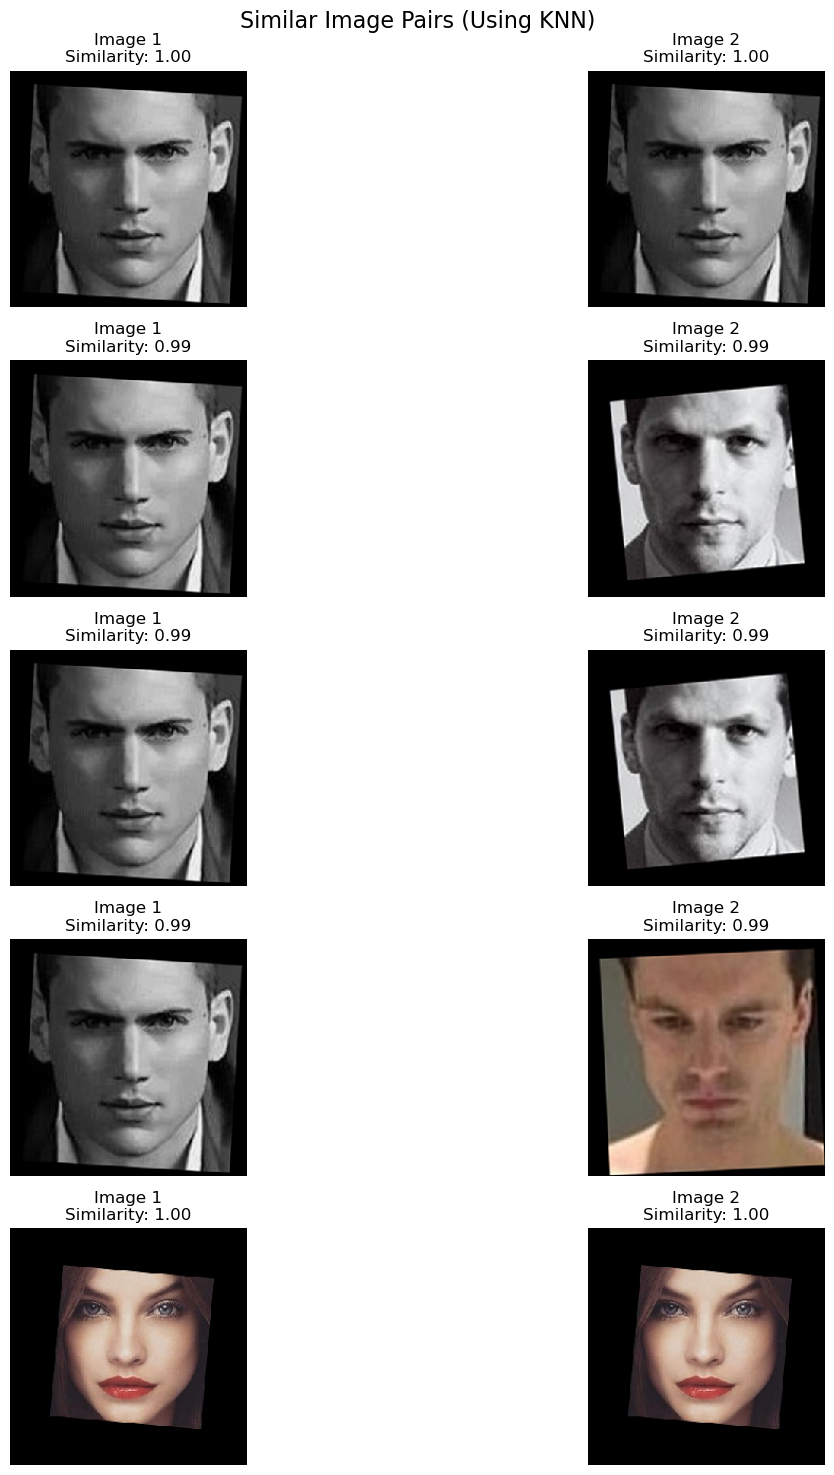

No dissimilar image pairs (using knn) pairs to visualize.


In [54]:
def visualize_image_pairs(pairs, title, num_pairs=5):
    """
    Visualize image pairs (similar or dissimilar).
    
    Parameters:
    - pairs: List containing image paths and their similarity score.
    - title: Title for the visualization
    - num_pairs: Number of pairs to visualize
    """
    if not pairs:
        print(f"No {title.lower()} pairs to visualize.")
        return

    # Select a subset of pairs to display
    pairs_to_display = pairs[:num_pairs]

    plt.figure(figsize=(15, num_pairs * 3))

    for idx, (path1, path2, similarity) in enumerate(pairs_to_display):
        # Load and display the first image
        img1 = load_img(path1, target_size=(224, 224))
        plt.subplot(num_pairs, 2, idx * 2 + 1)
        plt.imshow(img1)
        plt.title(f"Image 1\nSimilarity: {similarity:.2f}")
        plt.axis('off')

        # Load and display the second image
        img2 = load_img(path2, target_size=(224, 224))
        plt.subplot(num_pairs, 2, idx * 2 + 2)
        plt.imshow(img2)
        plt.title(f"Image 2\nSimilarity: {similarity:.2f}")
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize similar pairs
visualize_image_pairs(knn_similar_pairs, "Similar Image Pairs (Using KNN)", num_pairs=5)

# Visualize dissimilar pairs
visualize_image_pairs(knn_dissimilar_pairs, "Dissimilar Image Pairs (Using KNN)", num_pairs=5)

> We observed that our model successfully identified around 75,000 similar pairs using a similarity threshold of 0.8. However, despite setting a dissimilarity threshold of 0.3, no dissimilar image pairs were detected.  
>
> This outcome suggests either that KNN performs optimally for identifying positive cases or that our dataset may not contain any image pairs meeting the 0.3 dissimilarity threshold. To verify this, we could manually review all possible image pairs. However, given the sheer volume—potentially numbering in the millions—this process would require more than 24 hours to complete, making it impractical.  
>
> It’s important to acknowledge, though, that even if KNN didn’t identify dissimilar pairs, such pairs are indeed present in our dataset.

***
***
# <u>PART C</u>
***

## <u>To build a face recognition system</u> | <u>Model Building and Inference</u>

### Apply PCA on the embedding vectors

> * We will apply PCA to simplify the high-dimensional embeddings into a more manageable number of features without losing essential information
> * It will retain the most significant features by selecting a specified number of principal components (n_components)
> * This will help us simplify our embeddings into a lower-dimensional space, making them efficient to process while retaining the essential characteristics of the images
> * PCA will also scale well for embeddings from large datasets with minimal computational overhead
>
> Here we will be reducing the dimensions to 100 and tranform our high dimension embedding to a smaller space capturing the most significant features of the embeddings with us, while retaining the most of the variance (important information) in the original data

In [55]:

def apply_pca(embeddings, n_components=50):
    """
    Applies PCA to reduce dimensionality of the embeddings.

    Parameters:
    - embeddings: Generated embeddings.
    - n_components: Number of principal components to keep.

    Returns:
    - reduced_embeddings: A numpy array of reduced embeddings.
    - paths: List of corresponding image paths for the reduced embeddings.
    """
    paths = list(embeddings.keys())
    embedding_vectors = np.array(list(embeddings.values()))

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embedding_vectors)

    print(f"PCA applied: Reduced dimensions to {n_components}.")
    return reduced_embeddings, paths, pca

# Apply PCA to embeddings
reduced_embeddings, image_paths, pca_model = apply_pca(image_embeddings, n_components=100)


PCA applied: Reduced dimensions to 100.


### Build and train a SVM classifier on top of it

> For this, first we will prepare the data for our SVM model building where we will create a method to
> * extract labels (e.g., actor names) from the directory structure of the image paths
> * encode them into numerical format using a LabelEncoder, preparing them for training
> * split the reduced embeddings and encoded labels into training and testing sets using an 80-20 split
> * output the train-test data (X_train, X_test, y_train, y_test) along with the fitted label encoder

In [56]:

def prepare_data_for_svm(image_paths, labels, embeddings):
    """
    Prepares data and labels for SVM training.

    Parameters:
    - image_paths: List of image paths corresponding to embeddings.
    - labels: List of labels (actor names).
    - embeddings: Reduced embedding

    Returns:
    - X_train, X_test, y_train, y_test: Train-test split for embeddings and labels.
    - label_encoder: Fitted LabelEncoder for mapping labels.
    """
    # Encode labels
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, encoded_labels, test_size=0.2, random_state=42
    )

    print(f"Data prepared for SVM: {len(X_train)} training samples, {len(X_test)} testing samples.")
    return X_train, X_test, y_train, y_test, label_encoder

# Extract labels from image paths
labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]

# Prepare data for SVM
X_train, X_test, y_train, y_test, label_encoder = prepare_data_for_svm(
    image_paths, labels, reduced_embeddings
)


Data prepared for SVM: 15040 training samples, 3760 testing samples.


> Now that our data is ready, we will build our SVM model.
>
> We will first initialize a linear SVM model to perform classification by choosing 'linear' kernel as it's simple and effifienct in high-dimensional spaces like image embeddings. We will then train our model and calculate the accuracy around the trained model

In [57]:

def train_svm(X_train, y_train):
    """
    Trains an SVM classifier on the training data.

    Parameters:
    - X_train: Training embeddings.
    - y_train: Training labels.

    Returns:
    - svm_model: Trained SVM model.
    """
    svm_model = SVC(kernel='linear', probability=True, random_state=42)
    # Train the model
    start_time = time.time()
    print("Starting SVM training...")
    svm_model.fit(X_train, y_train)  # Fit the model on the entire dataset
    end_time = time.time()
    
    total_time = end_time - start_time
    print("SVM training complete.")
    
    print(f"Total time to Train SVM model: {total_time / 60:.2f} minutes")

    print("SVM training completed.")
    return svm_model

# Train the SVM model
svm_model = train_svm(X_train, y_train)

# Evaluate SVM performance on the test set
y_pred = svm_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Starting SVM training...
SVM training complete.
Total time to Train SVM model: 2.75 minutes
SVM training completed.
Classification Report:
                               precision    recall  f1-score   support

              pins_Aaron Paul       0.06      0.05      0.05        22
              pins_Aaron_Paul       0.10      0.10      0.10        21
            pins_Alvaro Morte       0.06      0.06      0.06        18
            pins_Alvaro_Morte       0.07      0.12      0.09        17
             pins_Amanda_Crew       0.73      0.68      0.70        28
          pins_Amaury Nolasco       0.14      0.09      0.11        32
          pins_Amaury_Nolasco       0.06      0.10      0.08        21
               pins_Anna Gunn       0.00      0.00      0.00        10
               pins_Anna_Gunn       0.00      0.00      0.00        13
    pins_Benedict Cumberbatch       0.06      0.07      0.06        14
    pins_Benedict_Cumberbatch       0.00      0.00      0.00        16
        

### Use the trained SVM model to predict the labels of the test images

> Here, we will generate embeddings for the test images and apply PCA to reduce their dimensionality, making them comparable to the embeddings used during training

In [58]:
# Paths to the test images
test_image_path_1 = 'C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 9 - Computer Vision (Week 32 to Week 37)/Project/Datasets/Dwayne+Johnson4.jpg'
test_image_path_2 = 'C:/Users/pri96/OneDrive/Documents/AI and ML PGP/Module 9 - Computer Vision (Week 32 to Week 37)/Project/Datasets/Benedict+Cumberbatch9.jpg'
test_images = [test_image_path_1, test_image_path_2]

# Generate embeddings for test images
test_embeddings = generate_embeddings(test_images, model)

# Apply PCA to reduce the dimensionality of test embeddings
test_reduced_embeddings = pca_model.transform(np.array(list(test_embeddings.values())))


Predicting image 1 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicting image 2 of 18800
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


> Now that we have transformed our model, we will predict the labels for the test images using our trained SVM model, decode the results using the LabelEncoder, and return the predicted class labels with the test image paths we entered

In [59]:
def predict_labels(svm_model, embeddings, label_encoder):
    """
    Predicts labels for given embeddings using the trained SVM model.

    Parameters:
    - svm_model: Trained SVM model.
    - embeddings: Embeddings of test images.
    - label_encoder: Fitted LabelEncoder for decoding predictions.

    Returns:
    - predictions: Decoded label predictions.
    """
    predictions = svm_model.predict(embeddings)
    decoded_predictions = label_encoder.inverse_transform(predictions)
    return decoded_predictions



> Now, let's also visualize our predicted images

Image: Dwayne+Johnson4.jpg - Predicted Label: pins_sean_pertwee
Image: Benedict+Cumberbatch9.jpg - Predicted Label: pins_Benedict Cumberbatch


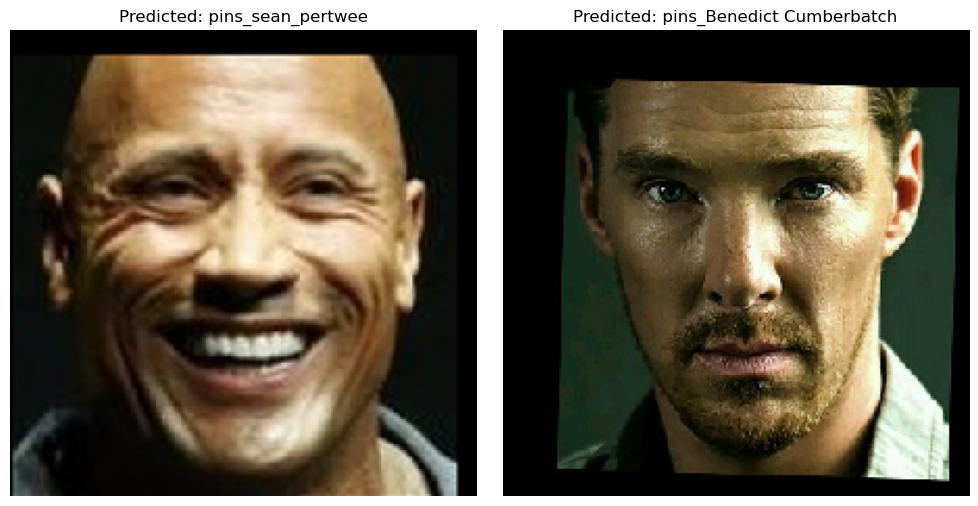

In [60]:


def visualize_predictions(image_paths, predictions):
    """
    Visualize test images with their predicted labels.

    Parameters:
    - image_paths: List of test image paths.
    - predictions: List of predicted labels.
    """
    plt.figure(figsize=(10, 5))
    for i, (img_path, prediction) in enumerate(zip(image_paths, predictions)):
        # Load and display the image
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {prediction}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Predict labels for test images
predicted_labels = predict_labels(svm_model, test_reduced_embeddings, label_encoder)

# Display predictions along with test images
for img_path, label in zip(test_images, predicted_labels):
    print(f"Image: {os.path.basename(img_path)} - Predicted Label: {label}")

# Visualize predictions
visualize_predictions(test_images, predicted_labels)


> With this we can see that our model is perfectly able to identify the test images and able to predit them corerctly. We can see the name on top of each predicted image which matches with the test image name.

***
***
# <u>Actionable Insights & Recommendations</u>
***

### Write down insights from the analysis conducted 

 - Insights written for each of the analysis conducted. Included answers to the questions like below:
     * What is the logic being used?
     * How is it related to the problem statement given?
     * What alternative can be used? Why did we choose the chosen logic?
     * What is the outcome and how do we benefit from that?
     * Etc, etc...

### Provide actionable business recommendations

Also, provided actions for business as recommendations for each analysis conducted. Included the benefits and how do they help business shape their organisation

***
***
# <u>Notebook Overall Quality</u>
***

 - Attempted to structure the code well. Went from one question to another with clear transition and divisions
 - Add comments wherever necessary to explain the changes
 - No errors in code, all code runs smoothly
 - All the step by step outputs are visible for each question asked

***
***
# ------------------------------------------ <u>END OF PROJECT</u> ------------------------------------------
***
***